# Machine Learning Models with Hyperparameter Tuning

### Machine Learning Algorithms:
- Logistic Regression
- Random Forest
- XGBoost 
- Decision Tree
- Support Vector Machine (SVM)
- Adaboost

In [1]:
## Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, ConfusionMatrixDisplay

## Model Imports
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Feature Engineering
from sklearn.feature_selection import mutual_info_classif, chi2, SequentialFeatureSelector
from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')  

# Methods
## Feature Engineering (In Analysis Code)
- Correlation Matrix
- Feature Importance 
- Chi-Square Test

## Feature Selection 
- Forward Feature Selection
- Backward Feature Selection
- PCA

## Evaluation
- Accuracy, Precision, Recall, F1-Score, ROC AUC, Standard Dev, Confusion Matrix
- ROC Curve & Precision-Recall Curve

In [2]:
## feature selection methods

def apply_ffs(model, xtrain, xtest, ytrain, x):
    print("--------------- Applying FFS ---------------")
    # Apply forward feature selection 
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward')
    Xtrain_selected = sfs.fit_transform(xtrain, ytrain)
    Xtest_selected = sfs.transform(xtest)

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [x[i] for i in selected_feature_indices]

    print(F"\nFeatures selected by Forward Feature Selection: {Xtrain_selected.shape[1]}")
    print(F"\nFeatures selected by Forward Feature Selection: {selected_feature_names}")
    
    return Xtrain_selected, Xtest_selected 

def apply_bfs(model, xtrain, xtest, ytrain, x):
    print("--------------- Applying BFS ---------------")
    # Apply backward feature selection 
    sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='backward')
    Xtrain_selected = sfs.fit_transform(xtrain, ytrain)
    Xtest_selected = sfs.transform(xtest)

    # Get the indices of selected features
    selected_feature_indices = sfs.get_support(indices=True)

    # Get the names of selected features
    selected_feature_names = [x[i] for i in selected_feature_indices]

    print(F"\nFeatures selected by Backward Feature Selection: {Xtrain_selected.shape[1]}")
    print(F"\nFeatures selected by Backward Feature Selection: {selected_feature_names}")
    
    return Xtrain_selected, Xtest_selected 

def apply_pca(xtrain, xtest, x, components):
    print("--------------- Applying PCA ---------------")

    pca = PCA(n_components = components) 

    Xtrain_pca = pca.fit_transform(xtrain)
    Xtest_pca = pca.transform(xtest)

    #get number of components
    components = pca.components_
    
    # Identifying top contributing features for each principal component
    top_features_per_component = {}
    for i, component in enumerate(components):
        # Getting indices of top contributing features for this component
        top_feature_indices = np.argsort(-np.abs(component))[:3]
        # Mapping indices to feature names
        top_features = [x[idx] for idx in top_feature_indices]
        top_features_per_component[i] = top_features
        
    print(f"Number of Principal Components: {pca.n_components_}")
    for component, features in top_features_per_component.items():
        print(f"Component {component}: {features}")
    
    return Xtrain_pca, Xtest_pca

In [3]:
## evaluation functions 

def evaluate(ytest, ypred, model, xtrain, ytrain):
    
    accuracy = accuracy_score(ytest, ypred)
    precision = precision_score(ytest, ypred)
    recall = recall_score(ytest, ypred)
    f1score = f1_score(ytest, ypred)
    auc = roc_auc_score(ytest, ypred)
    cross_val = cross_val_score(model, xtrain, ytrain, scoring='accuracy', cv=5)
    std_dev = cross_val.std()
    conf_matrix = confusion_matrix(ytest, ypred)
    
    print("\n--------------- Evaluation ---------------")
    print(f'Accuracy: {accuracy:.3}')
    print(f'Precision: {precision:.3}')
    print(f'Recall: {recall:.3}')
    print(f'F1 Score: {f1score:.3}')
    print(f'ROC AUC: {auc:.3}')
    print(f'Standard Deviaiton (Accuracy): {std_dev:.3}')
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print(f'\nClassification Report: ')
    print(classification_report(ytest, ypred, target_names=['0 - Negative', '1 - Positive']))
    #print(f'\nConfusion Matrix: \n {conf_matrix}')
    print("\n--------------- Visual Evaluation ---------------")
    disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, cmap = 'cool')
    #disp.plot()
    fig = disp.figure_
    fig.set_figwidth(14)
    fig.set_figheight(5) 
    fig.suptitle('Confusion Matrix', fontsize = 15)
    plt.show()
    
    plot_roc_and_pr_curve(ytest, ypred)
    
    return accuracy, precision, recall, f1score, auc, std_dev
    
def plot_roc_and_pr_curve(ytrue, yscores):
    fpr, tpr, _ = roc_curve(ytrue, yscores)
    roc_auc = auc(fpr, tpr)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    
    ax[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    ax[0].legend(loc="lower right")
    #ax[0].show()
    
    precision, recall, _ = precision_recall_curve(ytrue, yscores)
    ax[1].step(recall, precision, where='post', color='b', alpha=0.7)
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall Curve')
    
    fig.suptitle('\nROC Curve & Precision-Recall Curve', fontsize = 15)
    plt.tight_layout() 
    plt.show()

## Hyper Parameter Grids

In [4]:
lr_params = {
    'penalty': ['l1', 'l2', 'elasticent'], # Regularisation Technique
    'C': [-4, 1.0, 0.5, 0.25, 0.1, 0.75, 20], # Penalty
    'random_state': [0, 1, 5, 10, 20, 100], # Random State Number
    'fit_intercept': [True, False], # Fit Intercept Method
    'solver': ['lbfgs', 'sag', 'saga', 'liblinear', 'newton-cg', 'newton-cholesky'], # Solver
    'max_iter': [10000, 100, 1000, 500], # Maximum Number of Iterations
    'n_jobs': ['None', -1] # Number of parallel jobsnone means 1
}

rf_params = {
    'n_estimators': [50, 100, 200, 300, 400, 500],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30, 40, 50],    # Maximum depth of the tree 
    'min_samples_split': [2, 5, 10],            # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],              # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                 # Method of selecting samples for training each tree
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for best split
    'criterion': ['gini', 'entropy']            # Function to measure the quality of a split
}

xgb_params = {
    'n_estimators': [50, 100, 200, 500],  # Number of boosting rounds
    'max_depth': [3, 6, 9],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used per tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used per tree
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction for further partitioning
    'reg_lambda': [0, 1, 10],  # L2 regularization (Ridge)
    'reg_alpha': [0, 1, 10]  # L1 regularization (Lasso)
}
    
dt_params = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples at a leaf node
    'criterion': ['gini', 'entropy'],  # Splitting function
    'splitter': ['best', 'random']  # Best split vs. random split
}

svm_params = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient (ignored for linear kernel)
    'degree': [2, 3, 4],  # Only used if kernel='poly'
}    
    
ada_params = {
    'n_estimators': [50, 100, 200, 500],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0],  # Shrinks the contribution of each weak learner
    'algorithm': ['SAMME', 'SAMME.R']  # AdaBoost algorithm variants
}

# Main Code

In [5]:
data = pd.read_csv('../processed_data/patient_data.csv')
print("Shape: ", data.shape)
data.head()

Shape:  (886, 59)


,heavy_or_extreme_menstrual_bleeding,menstrual_pain_(dysmenorrhea),painful_or_burning_pain_during_sex_(dyspareunia),pelvic_pain,irregular_or_missed_periods,cramping,abdominal_pain_or_pressure,back_pain,painful_bowel_movements,nausea,...,fever,hormonal_problems,bloating,feeling_sick,decreased_energy_or_exhaustion,abdominal_cramps_during_intercourse,insomnia_or_sleeplessness,acne_or_pimples,loss_of_appetite,endometriosis_yn
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,1,1,1,0,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,0,1,1
2,0,1,0,1,1,1,0,1,0,1,...,0,0,1,1,1,0,1,0,0,1
3,1,0,0,0,0,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
4,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
X = data.drop('endometriosis_yn', axis = 1)
y = data[['endometriosis_yn']]

In [7]:
X.head()

,heavy_or_extreme_menstrual_bleeding,menstrual_pain_(dysmenorrhea),painful_or_burning_pain_during_sex_(dyspareunia),pelvic_pain,irregular_or_missed_periods,cramping,abdominal_pain_or_pressure,back_pain,painful_bowel_movements,nausea,...,abnormal_uterine_bleeding,fever,hormonal_problems,bloating,feeling_sick,decreased_energy_or_exhaustion,abdominal_cramps_during_intercourse,insomnia_or_sleeplessness,acne_or_pimples,loss_of_appetite
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,1,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
2,0,1,0,1,1,1,0,1,0,1,...,0,0,0,1,1,1,0,1,0,0
3,1,0,0,0,0,1,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,1,1,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
y.head()

,endometriosis_yn
0,1
1,1
2,1
3,1
4,1


In [9]:
Xtrain, Xtest ,ytrain ,ytest = train_test_split(X, y, test_size=0.25, random_state=0)

In [10]:
print(Xtrain.shape)
print(Xtest.shape)

(664, 58)
(222, 58)


In [11]:
## For results

model_results = pd.DataFrame({'Metrics':['Accuracy', 'Precision', 'Recall', 'F1Score', 'ROC AUC', 'Standard Dev']})
model_results.head()

,Metrics
0,Accuracy
1,Precision
2,Recall
3,F1Score
4,ROC AUC


# Model Development
## Logistic Regression 
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.956
Recall: 0.94
F1 Score: 0.948
ROC AUC: 0.946
Standard Deviaiton (Accuracy): 0.00824

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.95      0.94       106
1 - Positive       0.96      0.94      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


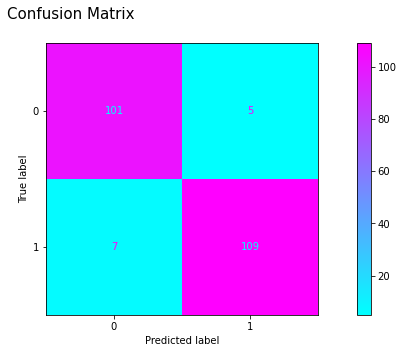

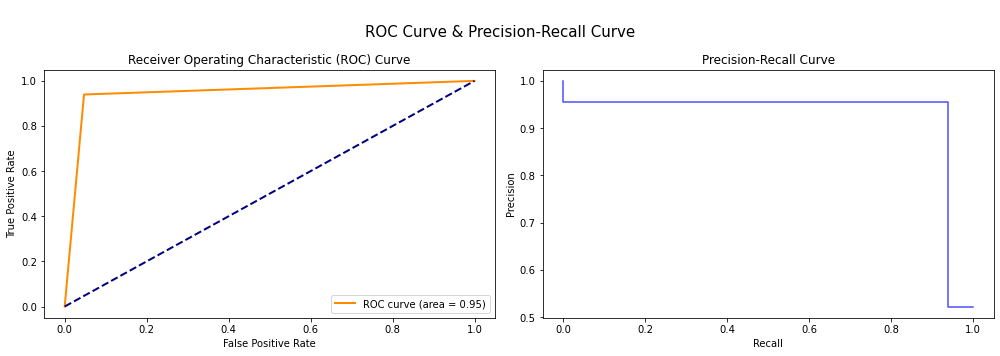

In [12]:
logistic_regression_model = LogisticRegression(max_iter = 10000)

logistic_regression_model.fit(Xtrain, ytrain)
ypred = logistic_regression_model.predict(Xtest)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain, ytrain)

model_results['Logistic Regression'] = results
#model_results

In [13]:
logistic_regression_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### HyperParameter Tuning

Fitting 5 folds for each of 12096 candidates, totalling 60480 fits
{'C': 1.0, 'fit_intercept': True, 'max_iter': 10000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'}
0.9171679197994986

--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.956
Recall: 0.94
F1 Score: 0.948
ROC AUC: 0.946
Standard Deviaiton (Accuracy): 0.0196

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.95      0.94       106
1 - Positive       0.96      0.94      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


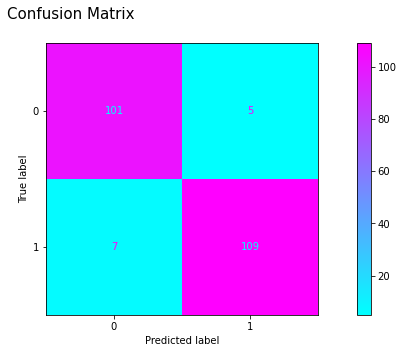

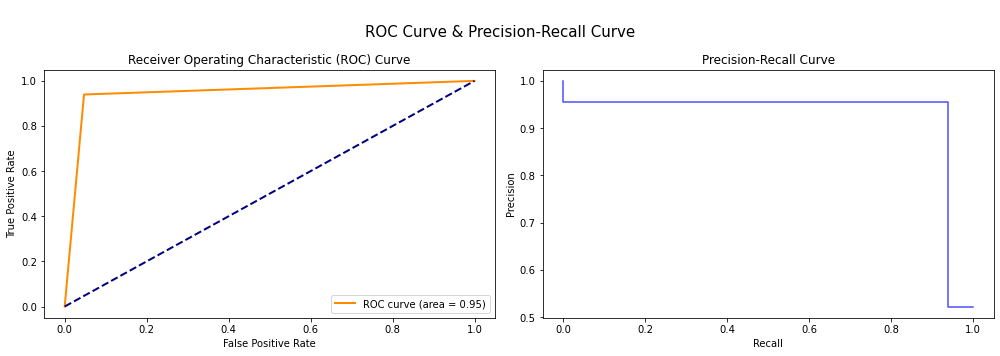

In [14]:
#base model (using the default)
logistic_regression_model = LogisticRegression()

gsLR = GridSearchCV(logistic_regression_model, lr_params, cv=5, n_jobs=-1, verbose=1)
gsLR.fit(Xtrain, ytrain)

print(gsLR.best_params_)
print(gsLR.best_score_)

gs_logistic_regression_model = gsLR.best_estimator_

gs_logistic_regression_model.fit(Xtrain, ytrain)
ypred = gs_logistic_regression_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_logistic_regression_model, Xtrain, ytrain)

model_results['Logistic Regression Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- LR FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'infertility', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'syncope_(fainting,_passing_out)', 'mood_swings', 'depression', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'bowel_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'acne_or_pimples', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation --------

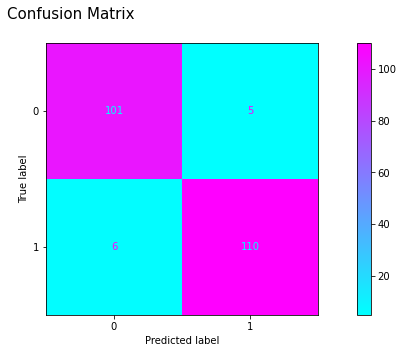

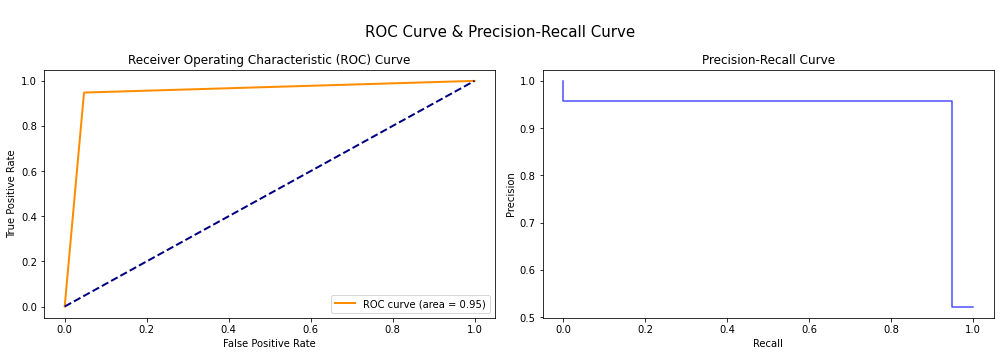

In [15]:
print("--------------- LR FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
logistic_regression_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = logistic_regression_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain_ffs, ytrain)

model_results['Logistic Regression FFS'] = results

### Hyperparameter Tuning

--------------- LR FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'infertility', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'syncope_(fainting,_passing_out)', 'mood_swings', 'depression', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'bowel_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'acne_or_pimples', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of

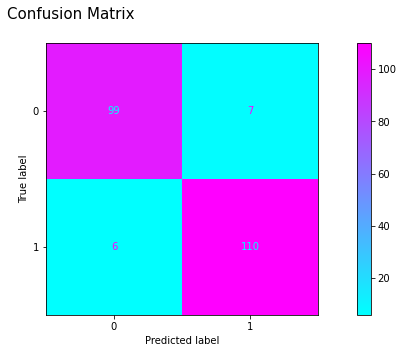

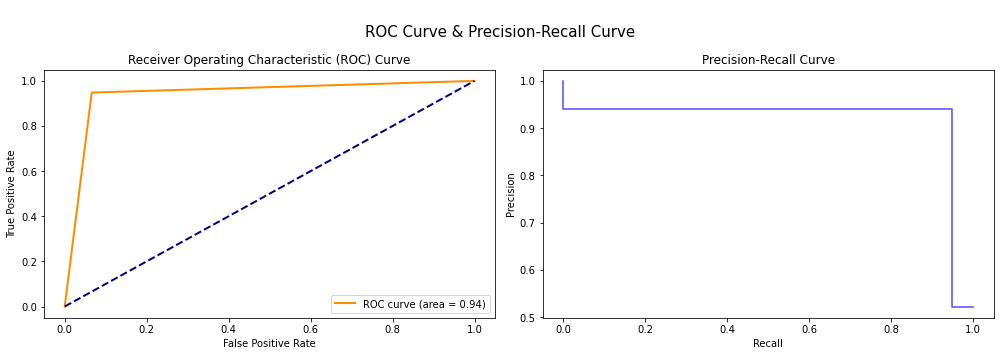

In [16]:
print("--------------- LR FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
logistic_regression_model = LogisticRegression()

gsLR = GridSearchCV(logistic_regression_model, lr_params, cv=5, n_jobs=-1, verbose=1)
gsLR.fit(Xtrain_ffs, ytrain)

print(gsLR.best_params_)
print(gsLR.best_score_)

print("--------------- Model Training ---------------")
gs_logistic_regression_model = gsLR.best_estimator_

# Train the model
gs_logistic_regression_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_logistic_regression_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_logistic_regression_model, Xtrain_ffs, ytrain)

model_results['Logistic Regression FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- LR BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'back_pain', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'bleeding', 'lower_back_pain', 'ovarian_cysts', 'constant_bleeding', 'ibs-like_symptoms', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'feeling_sick', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.

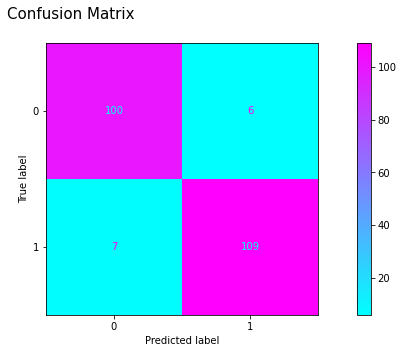

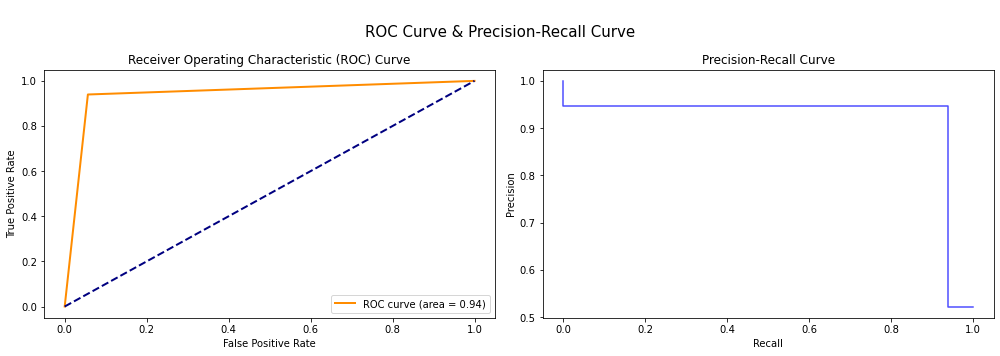

In [17]:
print("--------------- LR BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
logistic_regression_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = logistic_regression_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, logistic_regression_model, Xtrain_bfs, ytrain)

model_results['Logistic Regression BFS'] = results

--------------- LR BFS MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'back_pain', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'bleeding', 'lower_back_pain', 'ovarian_cysts', 'constant_bleeding', 'ibs-like_symptoms', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'feeling_sick', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each 

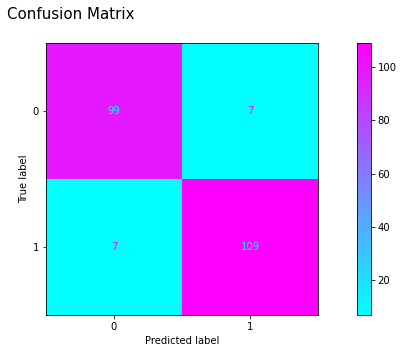

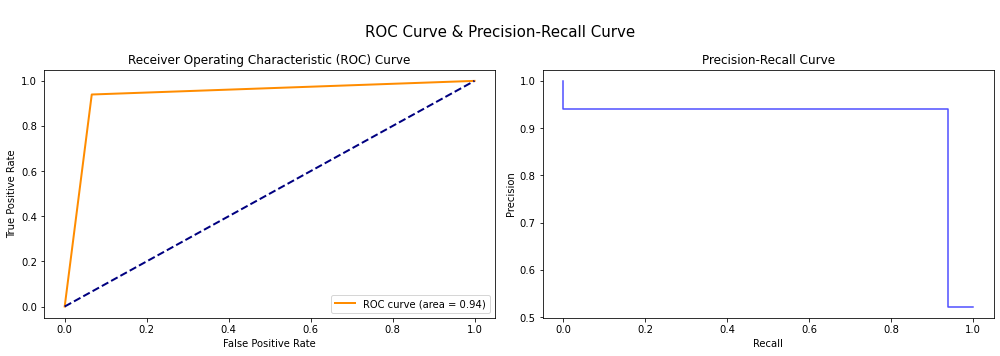

In [18]:
print("--------------- LR BFS MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(logistic_regression_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
logistic_regression_model = LogisticRegression()

gsLR = GridSearchCV(logistic_regression_model, lr_params, cv=5, n_jobs=-1, verbose=1)
gsLR.fit(Xtrain_bfs, ytrain)

print(gsLR.best_params_)
print(gsLR.best_score_)

print("--------------- Model Training ---------------")
gs_logistic_regression_model = gsLR.best_estimator_

# Train the model
gs_logistic_regression_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_logistic_regression_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_logistic_regression_model, Xtrain_bfs, ytrain)

model_results['Logistic Regression BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

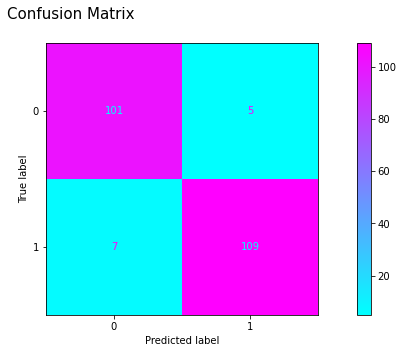

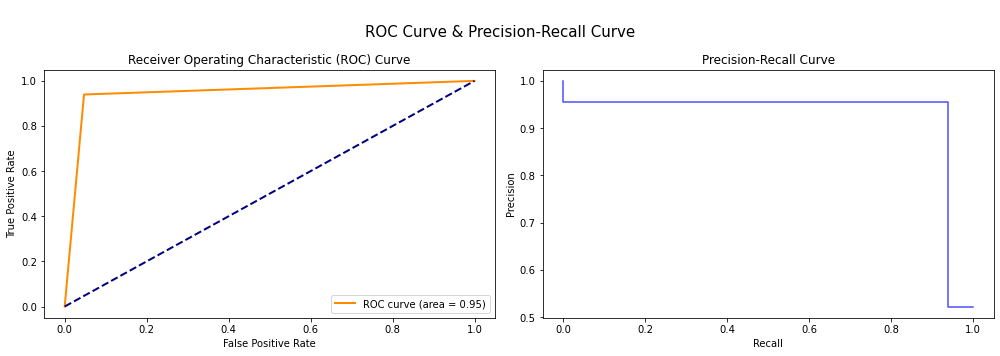

In [19]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_lr_model = LogisticRegression(max_iter = 1000)

# Train the model
pca_lr_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_lr_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_lr_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA(58)'] = results

### HyperParameter Tuning

--------------- LR PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dysp

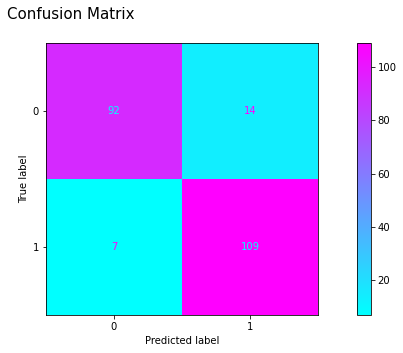

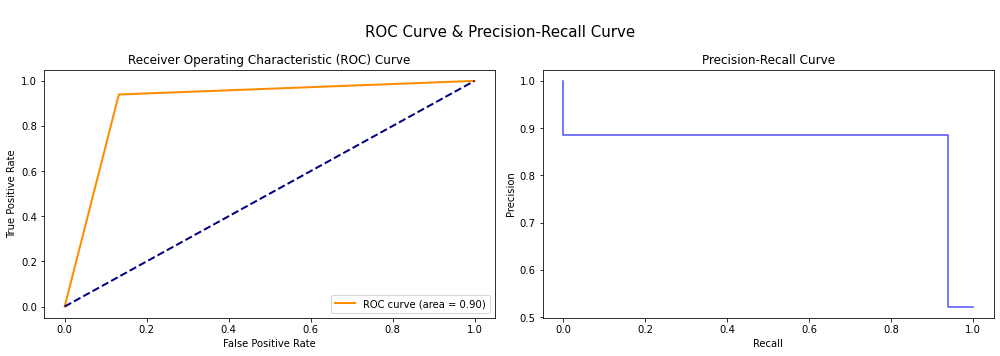

In [20]:
print("--------------- LR PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
logistic_regression_model = LogisticRegression()

gsLR = GridSearchCV(logistic_regression_model, lr_params, cv=5, n_jobs=-1, verbose=1)
gsLR.fit(Xtrain_pca, ytrain)

print(gsLR.best_params_)
print(gsLR.best_score_)

print("--------------- Model Training ---------------")
gs_logistic_regression_model = gsLR.best_estimator_

# Train the model
gs_logistic_regression_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_logistic_regression_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_logistic_regression_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA(58) Hyp'] = results

#### Version 2

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

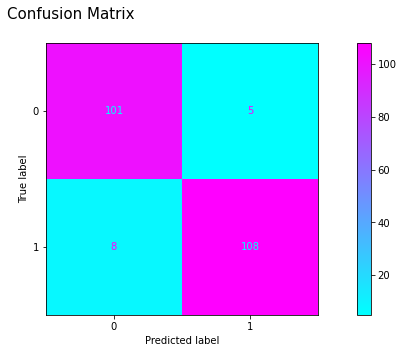

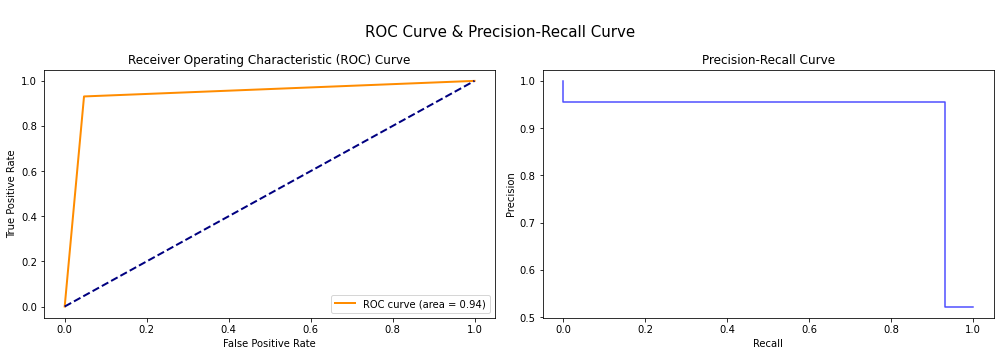

In [21]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_lr_model = LogisticRegression(max_iter = 1000)

# Train the model
pca_lr_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_lr_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_lr_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA (29)'] = results

### HyperParameter Tuning

--------------- LR PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareun

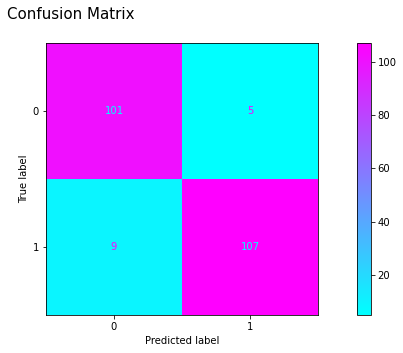

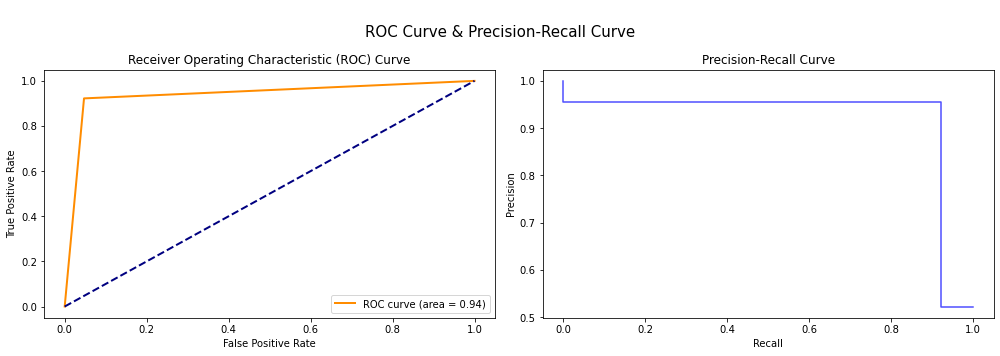

In [22]:
print("--------------- LR PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
logistic_regression_model = LogisticRegression()

gsLR = GridSearchCV(logistic_regression_model, lr_params, cv=5, n_jobs=-1, verbose=1)
gsLR.fit(Xtrain_pca, ytrain)

print(gsLR.best_params_)
print(gsLR.best_score_)

print("--------------- Model Training ---------------")
gs_logistic_regression_model = gsLR.best_estimator_

# Train the model
gs_logistic_regression_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_logistic_regression_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_logistic_regression_model, Xtrain_pca, ytrain)

model_results['Logistic Regression PCA(29) Hyp'] = results

## Random Forest
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.95
Precision: 0.973
Recall: 0.931
F1 Score: 0.952
ROC AUC: 0.951
Standard Deviaiton (Accuracy): 0.00824

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.93      0.97      0.95       106
1 - Positive       0.97      0.93      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


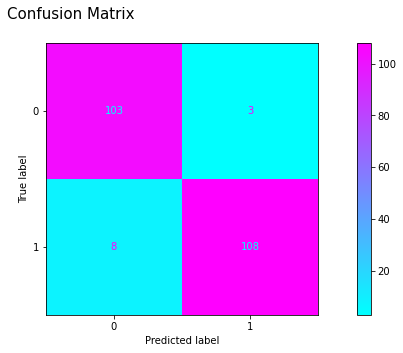

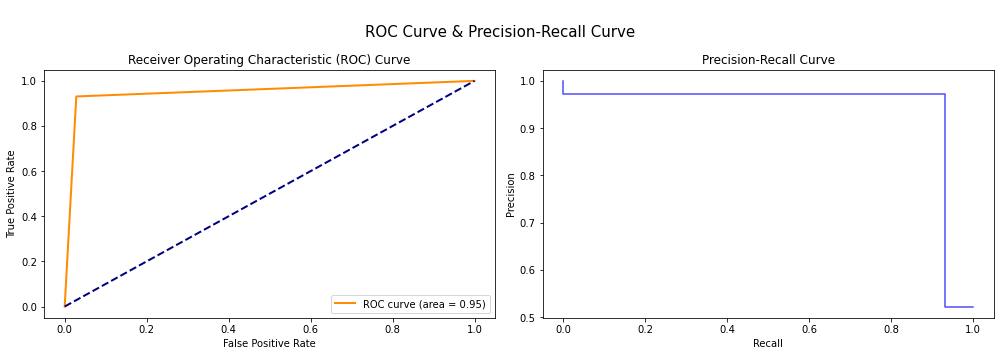

In [23]:
random_forest_model = RandomForestClassifier()

random_forest_model.fit(Xtrain, ytrain)
ypred = random_forest_model.predict(Xtest)

results = evaluate(ytest, ypred, random_forest_model, Xtrain, ytrain)

model_results['Random Forest'] = results

In [24]:
random_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### HyperParameter Tuning

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
0.9246867167919799

--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.948
Recall: 0.948
F1 Score: 0.948
ROC AUC: 0.946
Standard Deviaiton (Accuracy): 0.0236

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.94      0.94       106
1 - Positive       0.95      0.95      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


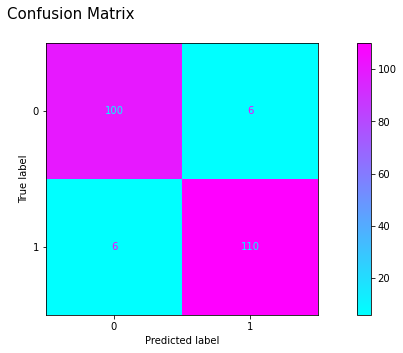

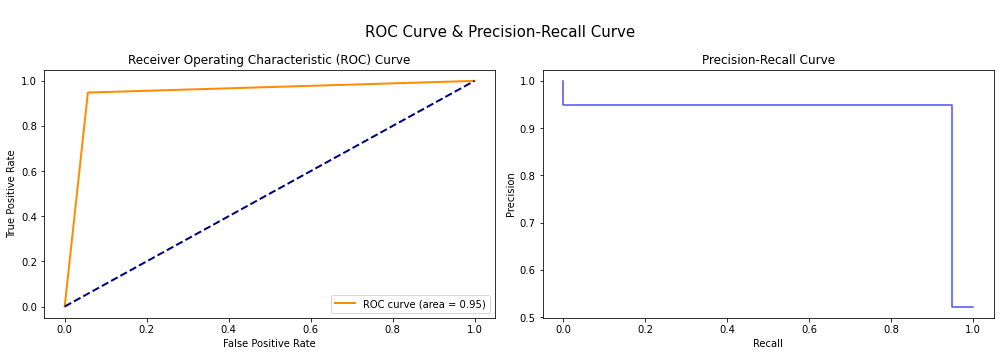

In [25]:
#base model (using the default)
random_forest_model = RandomForestClassifier()

gsRF = GridSearchCV(random_forest_model, rf_params, cv=5, n_jobs=-1, verbose=1)
gsRF.fit(Xtrain, ytrain)

print(gsRF.best_params_)
print(gsRF.best_score_)

gs_random_forest_model = gsRF.best_estimator_

gs_random_forest_model.fit(Xtrain, ytrain)
ypred = gs_random_forest_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_random_forest_model, Xtrain, ytrain)

model_results['Random Forest Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- RF FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'pelvic_pain', 'menstrual_clots', 'infertility', 'painful_cramps_during_period', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'mood_swings', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'excessive_bleeding', 'sharp_or_stabbing_pain', 'cysts_(unspecified)', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'hormonal_problems', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness']
--------------- Model Training ---------------

--------------- Evaluation -------------

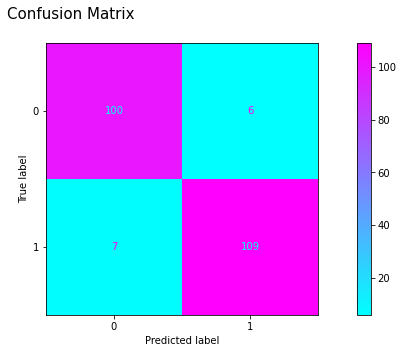

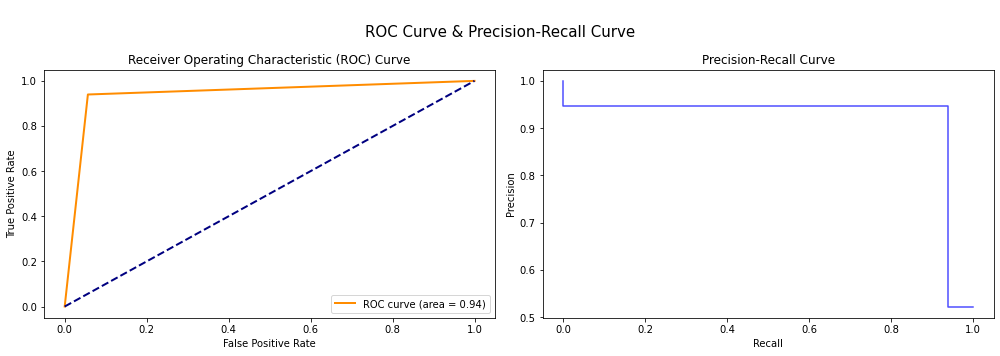

In [26]:
print("--------------- RF FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
random_forest_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = random_forest_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, random_forest_model, Xtrain_ffs, ytrain)

model_results['Random Forest FFS'] = results

### Hyperparameter Tuning

--------------- RF FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'infertility', 'painful_cramps_during_period', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'leg_pain', 'mood_swings', 'depression', 'bleeding', 'lower_back_pain', 'ovarian_cysts', 'constant_bleeding', 'ibs-like_symptoms', 'excessive_bleeding', 'vaginal_painorpressure', 'bowel_pain', 'anxiety', 'cysts_(unspecified)', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'acne_or_pimples', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 3888 candidates, totalling 19440 fits
{'bootstrap': True, 'crit

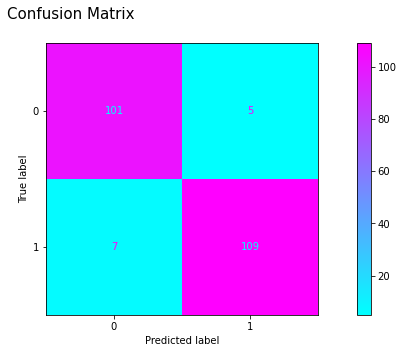

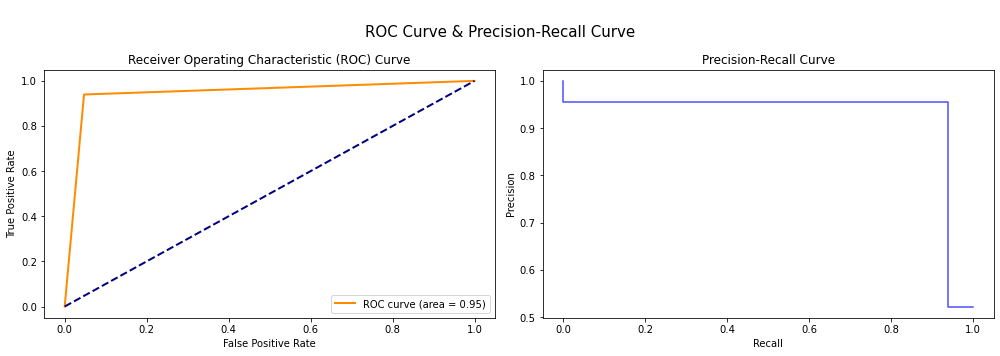

In [27]:
print("--------------- RF FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
random_forest_model = RandomForestClassifier()

gsRF = GridSearchCV(random_forest_model, rf_params, cv=5, n_jobs=-1, verbose=1)
gsRF.fit(Xtrain_ffs, ytrain)

print(gsRF.best_params_)
print(gsRF.best_score_)

print("--------------- Model Training ---------------")
gs_random_forest_model = gsRF.best_estimator_

# Train the model
gs_random_forest_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_random_forest_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_random_forest_model, Xtrain_ffs, ytrain)

model_results['Random Forest FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- RF BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'nausea', 'infertility', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'migraines', 'extreme_or_severe_pain', 'leg_pain', 'bleeding', 'lower_back_pain', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'pain_after_intercourse', 'hip_pain', 'anxiety', 'cysts_(unspecified)', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'feeling_sick', 'abdominal_cramps_during_intercourse', 'acne_or_pimples', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.928
Precision: 0.939
Recall: 0.922
F1 Score: 0.93
ROC AUC: 0.928
Standard Deviaiton (Accuracy): 0.0146

Clas

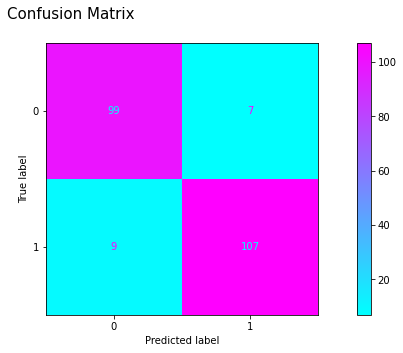

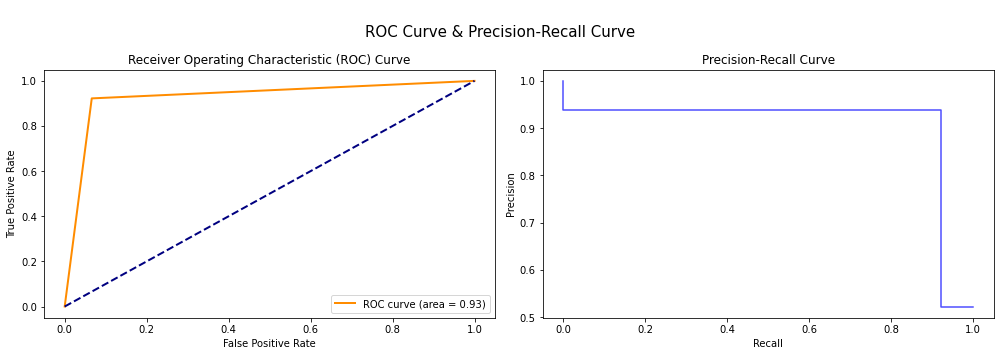

In [28]:
print("--------------- RF BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
random_forest_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = random_forest_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, random_forest_model, Xtrain_bfs, ytrain)

model_results['Random Forest BFS'] = results

### Hyperparameter Tuning

--------------- RF BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'back_pain', 'painful_bowel_movements', 'menstrual_clots', 'diarrhea', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'extreme_or_severe_pain', 'leg_pain', 'syncope_(fainting,_passing_out)', 'mood_swings', 'bleeding', 'ovarian_cysts', 'constant_bleeding', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'cysts_(unspecified)', 'dizziness', 'hormonal_problems', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'acne_or_pimples', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 3888 cand

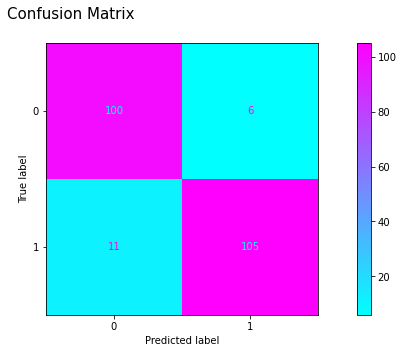

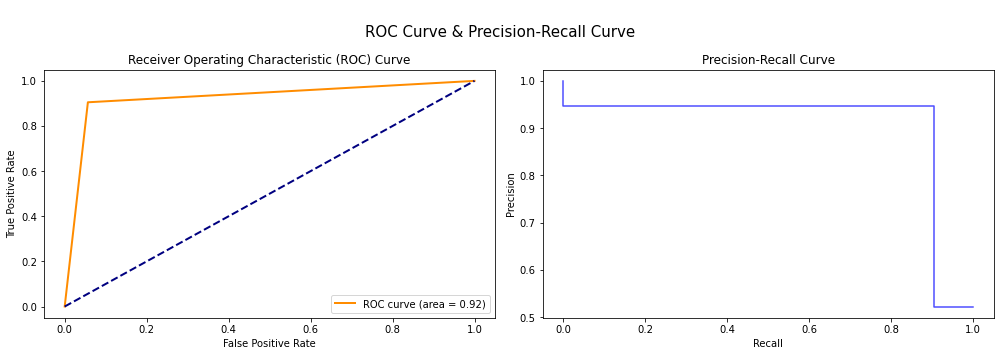

In [29]:
print("--------------- RF BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(random_forest_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
random_forest_model = RandomForestClassifier()

gsRF = GridSearchCV(random_forest_model, rf_params, cv=5, n_jobs=-1, verbose=1)
gsRF.fit(Xtrain_bfs, ytrain)

print(gsRF.best_params_)
print(gsRF.best_score_)

print("--------------- Model Training ---------------")
gs_random_forest_model = gsRF.best_estimator_

# Train the model
gs_random_forest_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_random_forest_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_random_forest_model, Xtrain_bfs, ytrain)

model_results['Random Forest BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- RF PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

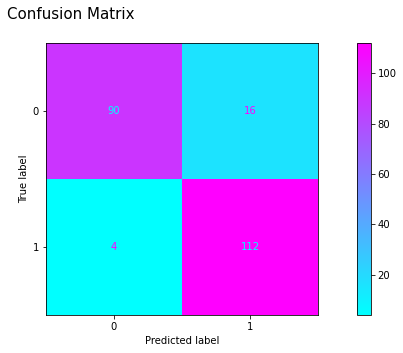

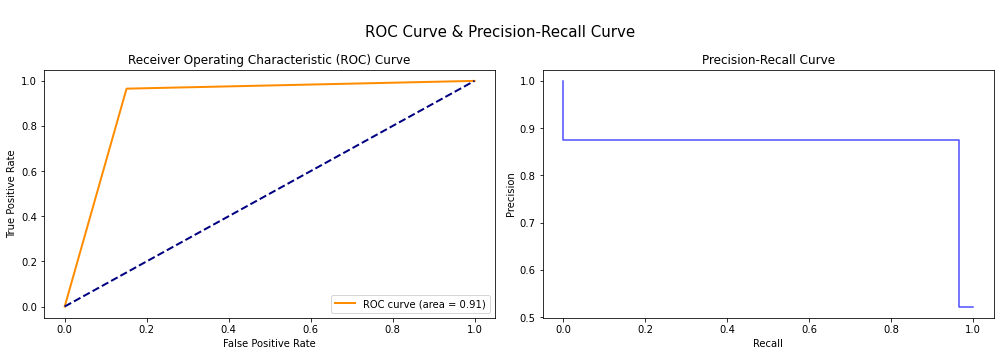

In [30]:
print("--------------- RF PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Random Forest model
pca_rf_model = RandomForestClassifier()

# Train the model
pca_rf_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_rf_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_rf_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA(58)'] = results

### Hyperparameter Tuning

--------------- RF PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dysp

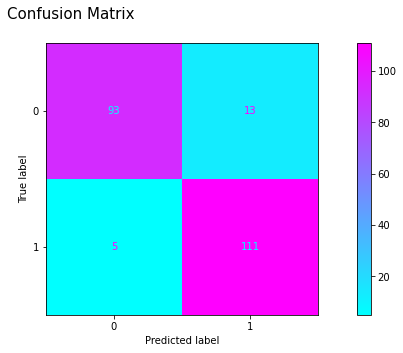

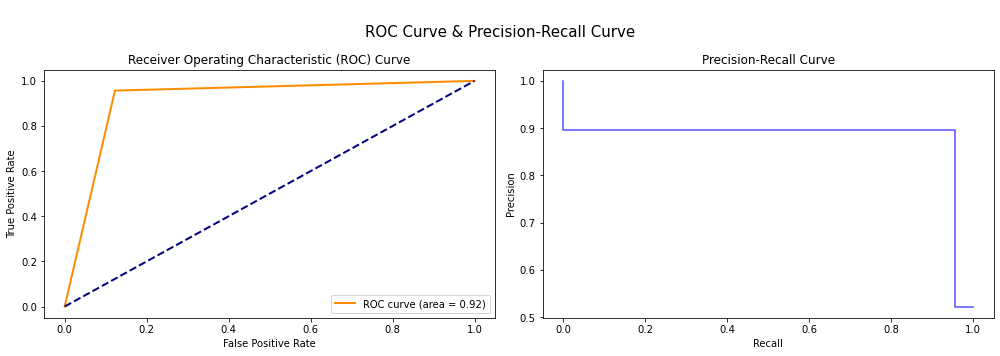

In [31]:
print("--------------- RF PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
random_forest_model = RandomForestClassifier()

gsRF = GridSearchCV(random_forest_model, rf_params, cv=5, n_jobs=-1, verbose=1)
gsRF.fit(Xtrain_pca, ytrain)

print(gsRF.best_params_)
print(gsRF.best_score_)

print("--------------- Model Training ---------------")
gs_random_forest_model = gsRF.best_estimator_

# Train the model
gs_random_forest_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_random_forest_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_random_forest_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA(58) Hyp'] = results

#### Version 2

--------------- RF PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimples

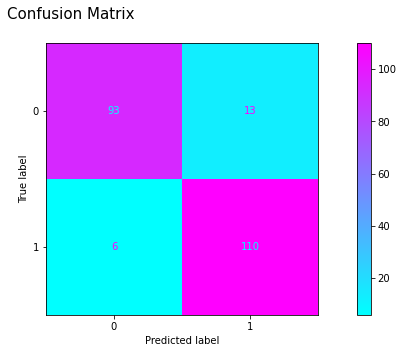

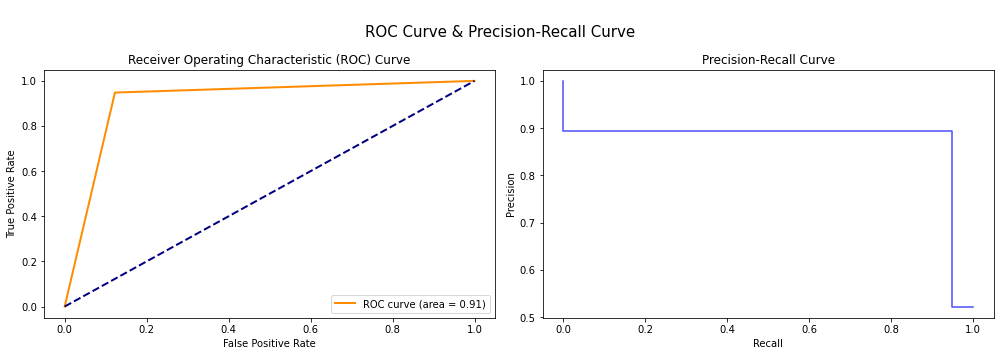

In [32]:
print("--------------- RF PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_rf_model = RandomForestClassifier()

# Train the model
pca_rf_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_rf_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_rf_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA (29)'] = results

### Hyperparameter Tuning

--------------- RF PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'ovarian_cysts', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(

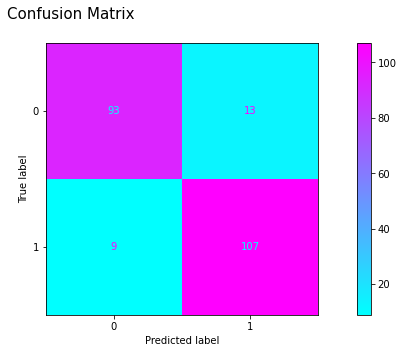

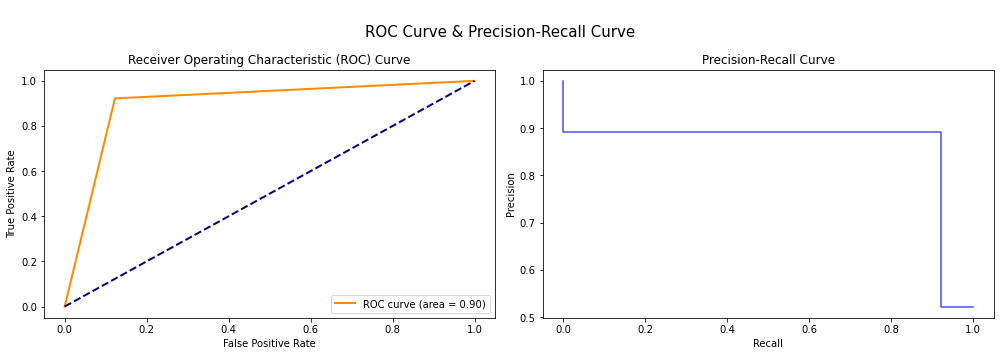

In [33]:
print("--------------- RF PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
random_forest_model = RandomForestClassifier()

gsRF = GridSearchCV(random_forest_model, rf_params, cv=5, n_jobs=-1, verbose=1)
gsRF.fit(Xtrain_pca, ytrain)

print(gsRF.best_params_)
print(gsRF.best_score_)

print("--------------- Model Training ---------------")
gs_random_forest_model = gsRF.best_estimator_

# Train the model
gs_random_forest_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_random_forest_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_random_forest_model, Xtrain_pca, ytrain)

model_results['Random Forest PCA(29) Hyp'] = results

## XGBoost
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.941
Recall: 0.957
F1 Score: 0.949
ROC AUC: 0.945
Standard Deviaiton (Accuracy): 0.0153

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.95      0.93      0.94       106
1 - Positive       0.94      0.96      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


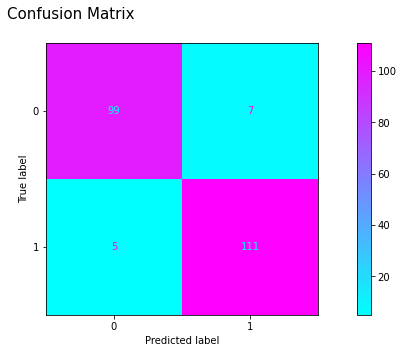

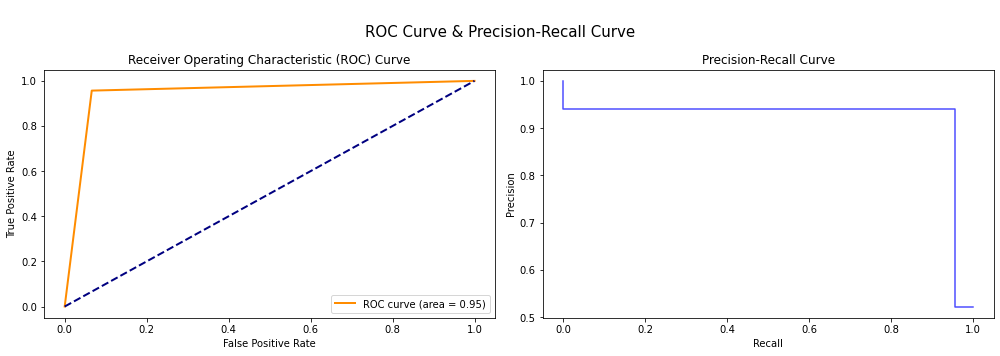

In [34]:
xgboost_model = XGBClassifier()

xgboost_model.fit(Xtrain, ytrain)
ypred = xgboost_model.predict(Xtest)

results = evaluate(ytest, ypred, xgboost_model, Xtrain, ytrain)

model_results['XGBoost'] = results

In [35]:
xgboost_model.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### Parameter Tuning 

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
0.9292093871041238

--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.933
Recall: 0.966
F1 Score: 0.949
ROC AUC: 0.945
Standard Deviaiton (Accuracy): 0.0103

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.96      0.92      0.94       106
1 - Positive       0.93      0.97      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


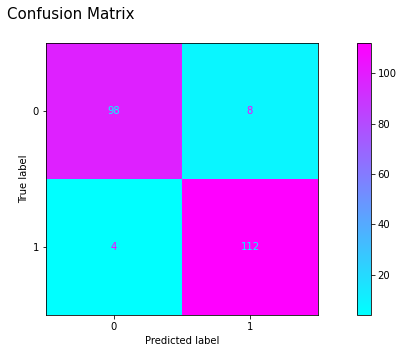

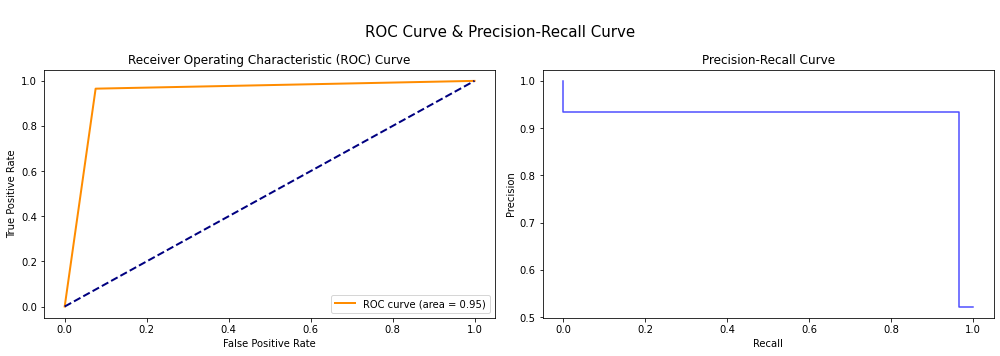

In [36]:
#base model (using the default)
xgboost_model = XGBClassifier()

gsXGB = GridSearchCV(xgboost_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
gsXGB.fit(Xtrain, ytrain)

print(gsXGB.best_params_)
print(gsXGB.best_score_)

gs_xgboost_model = gsXGB.best_estimator_

gs_xgboost_model.fit(Xtrain, ytrain)
ypred = gs_xgboost_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_xgboost_model, Xtrain, ytrain)

model_results['XGBoost Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- XGB FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'cramping', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'diarrhea', 'long_menstruation', 'fatigue_or_chronic_fatigue', 'stomach_cramping', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'hip_pain', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'cysts_(unspecified)', 'fever', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.919
Precision: 0.922
Recall: 0.922
F1 Scor

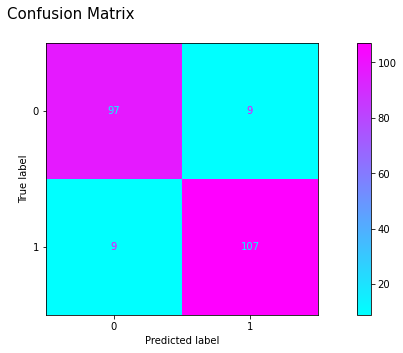

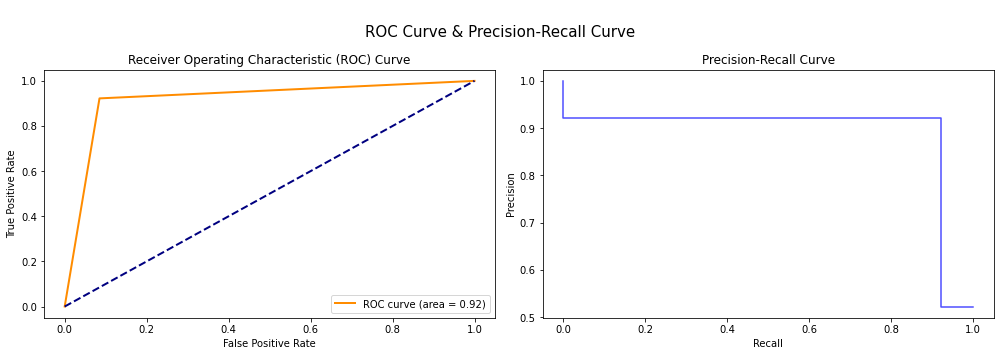

In [37]:
print("--------------- XGB FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
xgboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = xgboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, xgboost_model, Xtrain_ffs, ytrain)

model_results['XGBoost FFS'] = results


### Hyperparameter Tuning

--------------- XGB FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'cramping', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'diarrhea', 'long_menstruation', 'fatigue_or_chronic_fatigue', 'stomach_cramping', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'hip_pain', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'cysts_(unspecified)', 'fever', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 8748 candidates, totalling 43740 fits
{'colsample_bytree': 0.

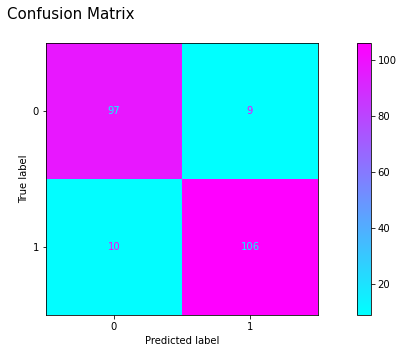

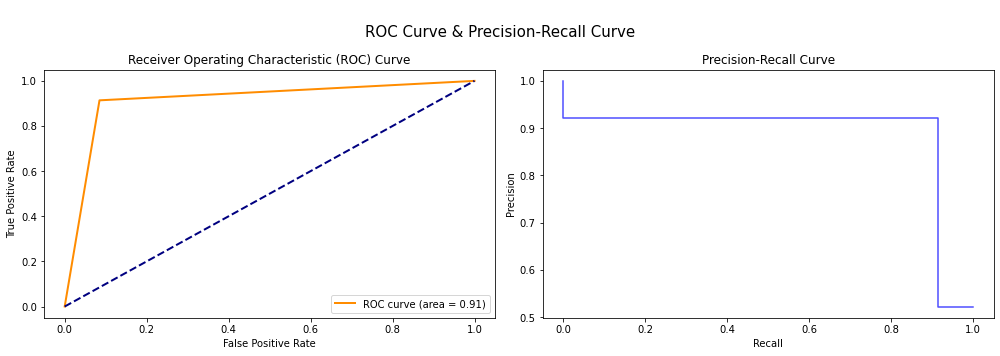

In [38]:
print("--------------- XGB FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
xgboost_model = XGBClassifier()

gsXGB = GridSearchCV(xgboost_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
gsXGB.fit(Xtrain_ffs, ytrain)

print(gsXGB.best_params_)
print(gsXGB.best_score_)

print("--------------- Model Training ---------------")
gs_xgboost_model = gsXGB.best_estimator_

# Train the model
gs_xgboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_xgboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_xgboost_model, Xtrain_ffs, ytrain)

model_results['XGBoost FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- XGB BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'leg_pain', 'bleeding', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'excessive_bleeding', 'vaginal_painorpressure', 'bowel_pain', 'cysts_(unspecified)', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'bloating', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy

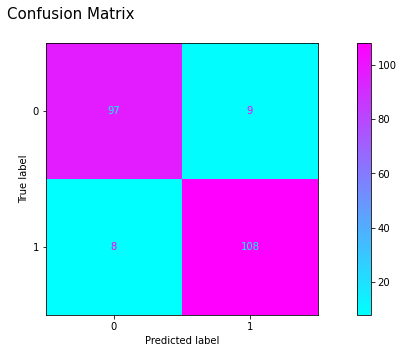

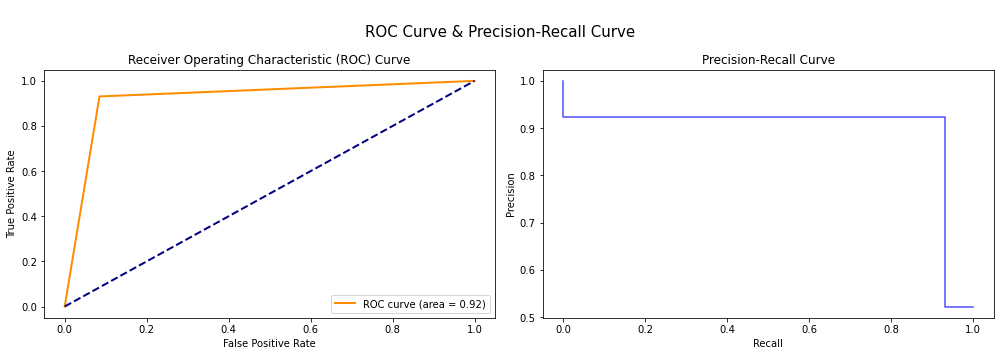

In [39]:
print("--------------- XGB BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
xgboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = xgboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, xgboost_model, Xtrain_bfs, ytrain)

model_results['XGBoost BFS'] = results

### Hyperparameter Tuning

--------------- XGB BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'leg_pain', 'bleeding', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'excessive_bleeding', 'vaginal_painorpressure', 'bowel_pain', 'cysts_(unspecified)', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'bloating', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 8748 candidates

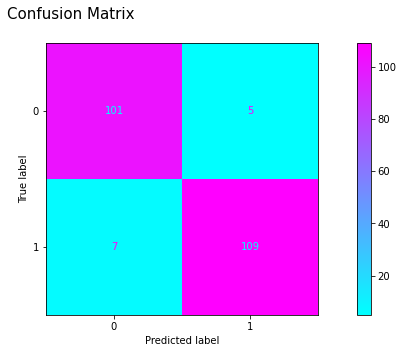

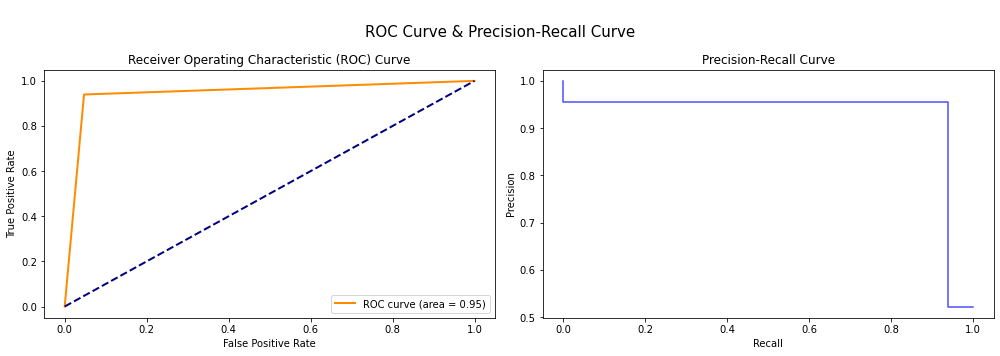

In [40]:
print("--------------- XGB BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(xgboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
xgboost_model = XGBClassifier()

gsXGB = GridSearchCV(xgboost_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
gsXGB.fit(Xtrain_bfs, ytrain)

print(gsXGB.best_params_)
print(gsXGB.best_score_)

print("--------------- Model Training ---------------")
gs_xgboost_model = gsXGB.best_estimator_

# Train the model
gs_xgboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_xgboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_xgboost_model, Xtrain_bfs, ytrain)

model_results['XGBoost BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- XGB PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_p

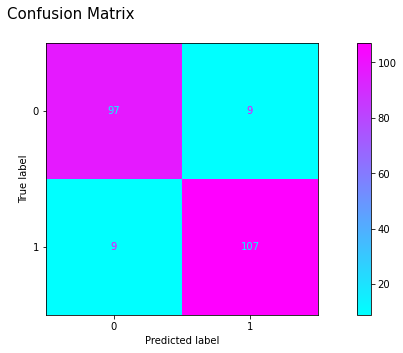

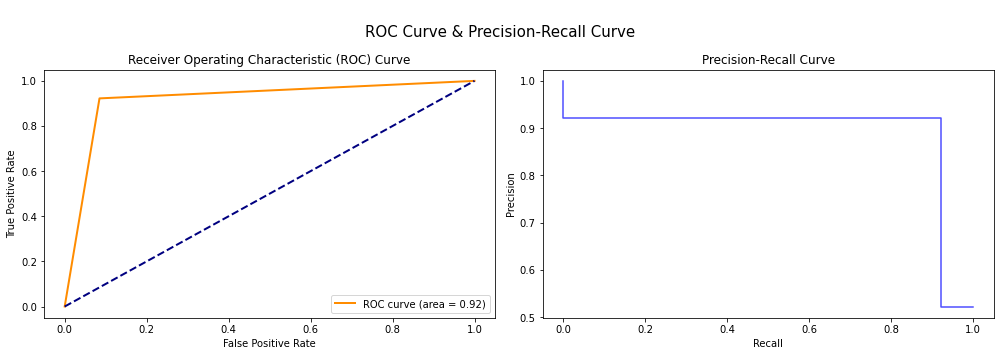

In [41]:
print("--------------- XGB PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_xgb_model = XGBClassifier()

# Train the model
pca_xgb_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_xgb_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_xgb_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA(58)'] = results

### Hyperparameter Tuning

--------------- XGB PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dys

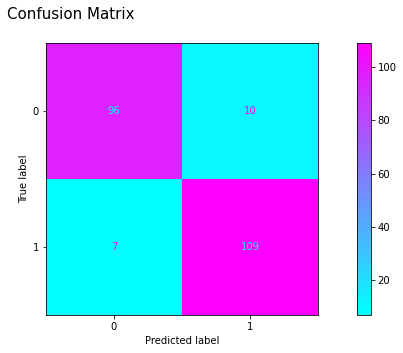

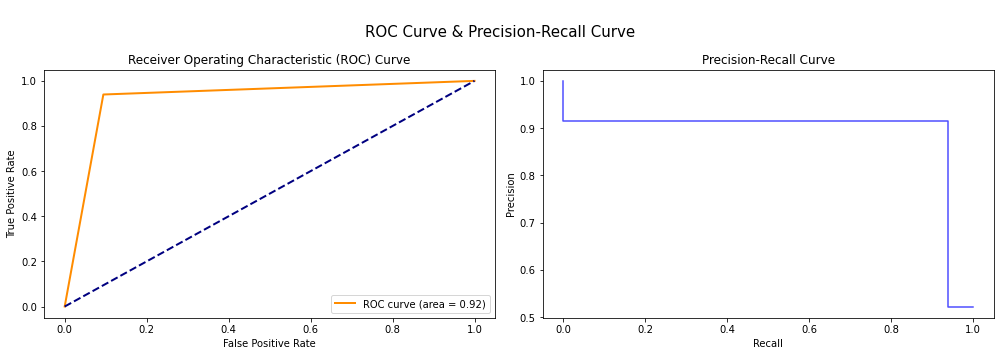

In [42]:
print("--------------- XGB PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
xgboost_model = XGBClassifier()

gsXGB = GridSearchCV(xgboost_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
gsXGB.fit(Xtrain_pca, ytrain)

print(gsXGB.best_params_)
print(gsXGB.best_score_)

print("--------------- Model Training ---------------")
gs_xgboost_model = gsXGB.best_estimator_

# Train the model
gs_xgboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_xgboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_xgboost_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA(58) Hyp'] = results

#### Version 2

--------------- XGB PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimple

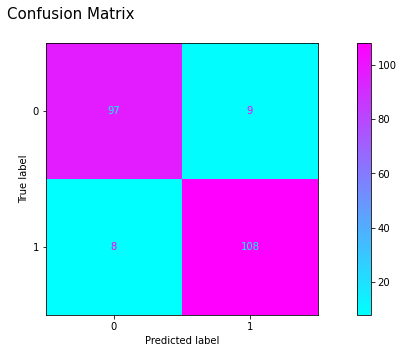

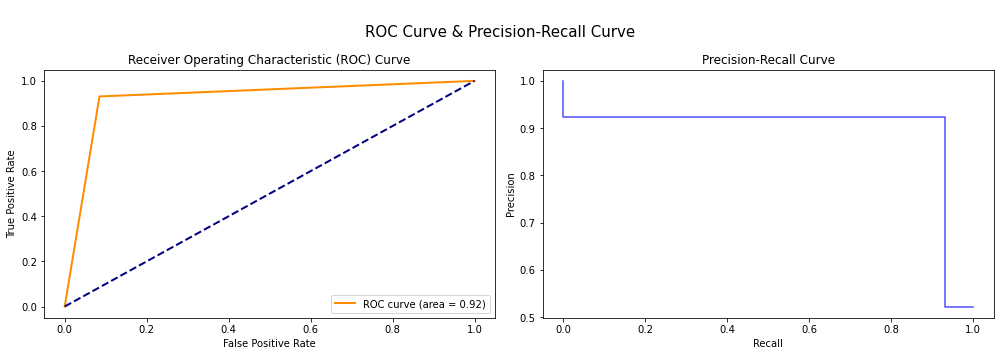

In [43]:
print("--------------- XGB PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_xgb_model = XGBClassifier()

# Train the model
pca_xgb_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_xgb_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_xgb_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA (29)'] = results

### Hyperparameter Tuning

--------------- XGB PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareu

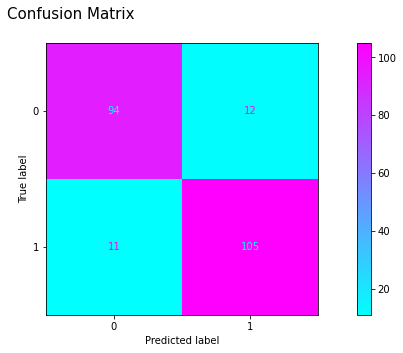

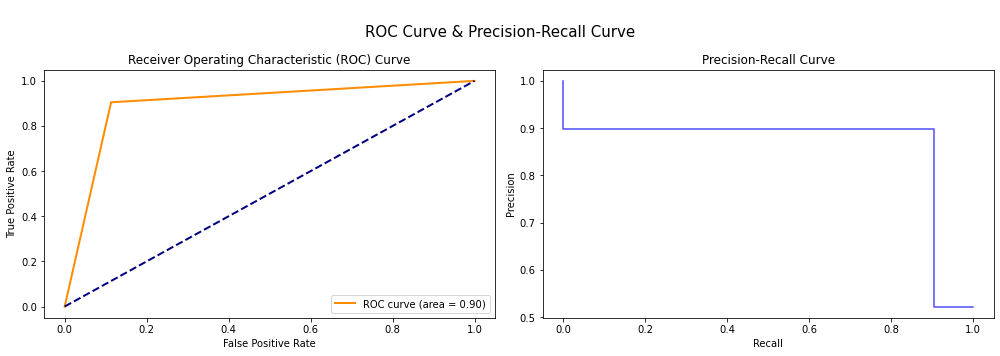

In [44]:
print("--------------- XGB PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
xgboost_model = XGBClassifier()

gsXGB = GridSearchCV(xgboost_model, xgb_params, cv=5, n_jobs=-1, verbose=1)
gsXGB.fit(Xtrain_pca, ytrain)

print(gsXGB.best_params_)
print(gsXGB.best_score_)

print("--------------- Model Training ---------------")
gs_xgboost_model = gsXGB.best_estimator_

# Train the model
gs_xgboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_xgboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_xgboost_model, Xtrain_pca, ytrain)

model_results['XGBoost PCA(29) Hyp'] = results

## Decision Tree
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.896
Precision: 0.897
Recall: 0.905
F1 Score: 0.901
ROC AUC: 0.896
Standard Deviaiton (Accuracy): 0.00999

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.90      0.89      0.89       106
1 - Positive       0.90      0.91      0.90       116

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222


--------------- Visual Evaluation ---------------


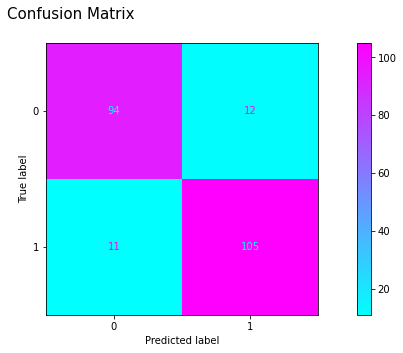

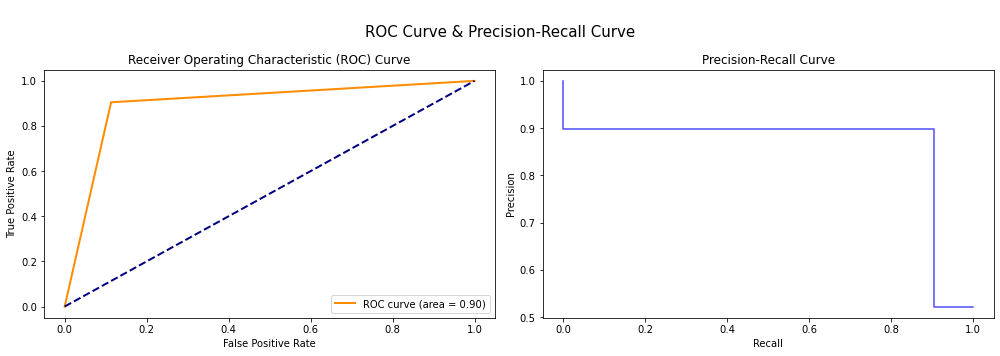

In [45]:
decision_tree_model = DecisionTreeClassifier()

decision_tree_model.fit(Xtrain, ytrain)
ypred = decision_tree_model.predict(Xtest)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain, ytrain)

model_results['Decision Tree'] = results

In [46]:
decision_tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

### Hyperparameter Tuning

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
0.8885737069947597

--------------- Evaluation ---------------
Accuracy: 0.896
Precision: 0.891
Recall: 0.914
F1 Score: 0.902
ROC AUC: 0.896
Standard Deviaiton (Accuracy): 0.0204

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.90      0.88      0.89       106
1 - Positive       0.89      0.91      0.90       116

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222


--------------- Visual Evaluation ---------------


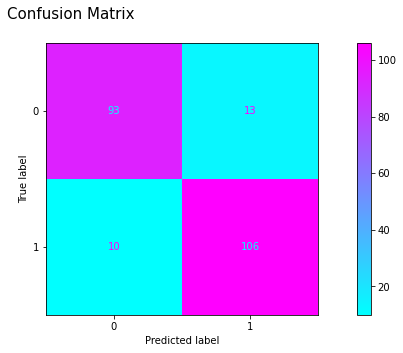

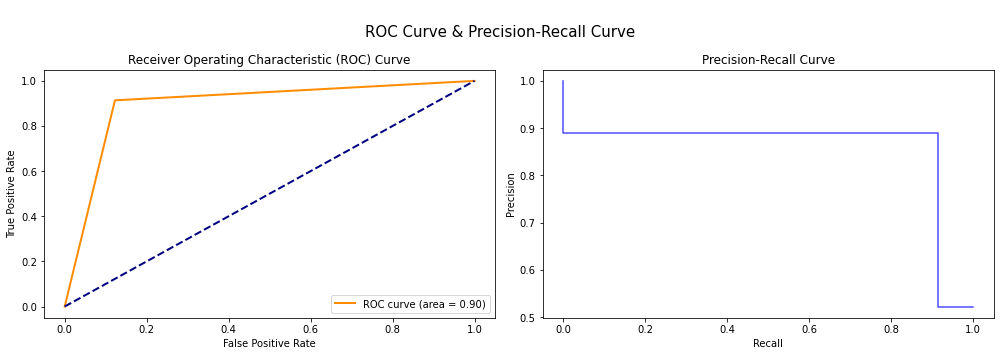

In [47]:
#base model (using the default)
decision_tree_model = DecisionTreeClassifier()

gsDT = GridSearchCV(decision_tree_model, dt_params, cv=5, n_jobs=-1, verbose=1)
gsDT.fit(Xtrain, ytrain)

print(gsDT.best_params_)
print(gsDT.best_score_)

gs_decision_tree_model = gsDT.best_estimator_

gs_decision_tree_model.fit(Xtrain, ytrain)
ypred = gs_decision_tree_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_decision_tree_model, Xtrain, ytrain)

model_results['Decision Tree Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- DT FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'irregular_or_missed_periods', 'cramping', 'painful_bowel_movements', 'infertility', 'painful_cramps_during_period', 'diarrhea', 'long_menstruation', 'stomach_cramping', 'irritable_bowel_syndrome_(ibs)', 'syncope_(fainting,_passing_out)', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'pain_after_intercourse', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'anxiety', 'cysts_(unspecified)', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'bloating', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.82
Precision: 0.822
Rec

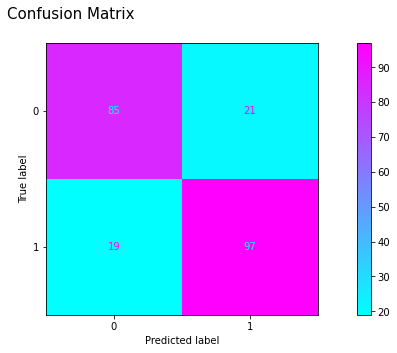

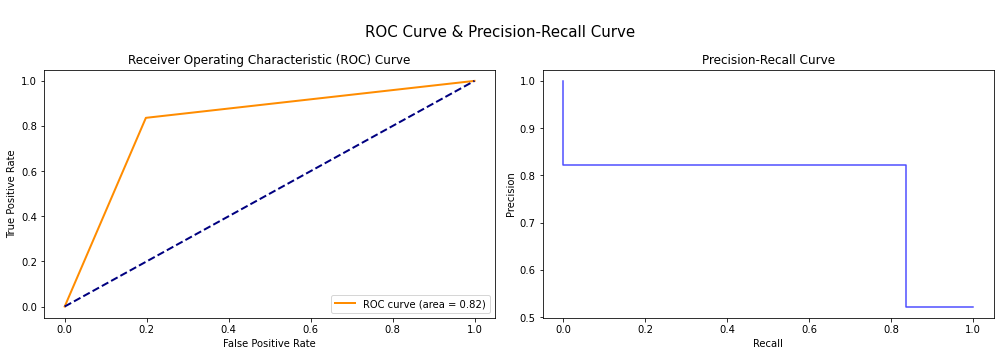

In [48]:
print("--------------- DT FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
decision_tree_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = decision_tree_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain_ffs, ytrain)

model_results['Decision Tree FFS'] = results

### Hyperparameter Tuning

--------------- DT FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'cramping', 'menstrual_clots', 'infertility', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'constipation_or_chronic_constipation', 'stomach_cramping', 'migraines', 'syncope_(fainting,_passing_out)', 'depression', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'painful_urination', 'pain_after_intercourse', 'ibs-like_symptoms', 'hip_pain', 'vaginal_painorpressure', 'anxiety', 'cysts_(unspecified)', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'bloating', 'feeling_sick', 'insomnia_or_sleeplessness', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5

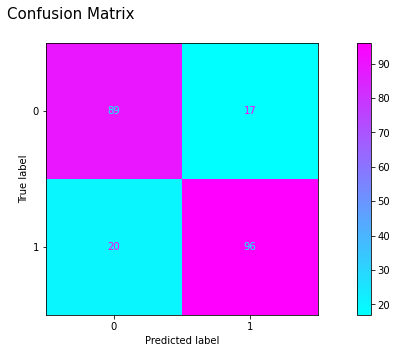

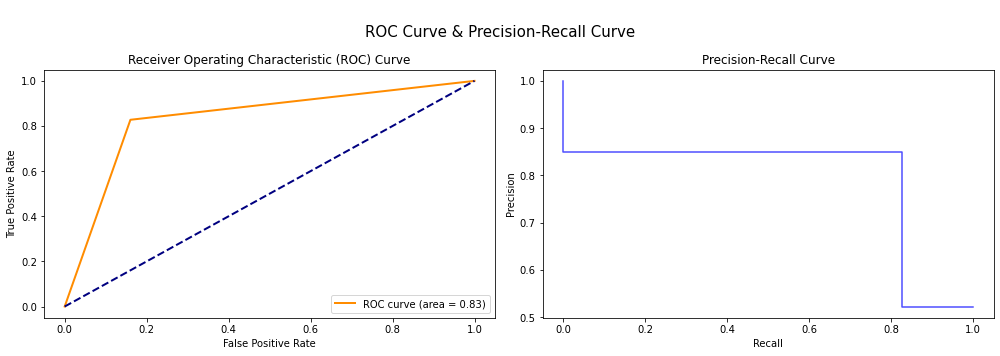

In [49]:
print("--------------- DT FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
decision_tree_model = DecisionTreeClassifier()

gsDT = GridSearchCV(decision_tree_model, dt_params, cv=5, n_jobs=-1, verbose=1)
gsDT.fit(Xtrain_ffs, ytrain)

print(gsDT.best_params_)
print(gsDT.best_score_)

print("--------------- Model Training ---------------")
gs_decision_tree_model = gsDT.best_estimator_

# Train the model
gs_decision_tree_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_decision_tree_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_decision_tree_model, Xtrain_ffs, ytrain)

model_results['Decision Tree FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- DT BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'abdominal_pain_or_pressure', 'back_pain', 'painful_bowel_movements', 'nausea', 'infertility', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'diarrhea', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'extreme_or_severe_pain', 'syncope_(fainting,_passing_out)', 'depression', 'bleeding', 'ovarian_cysts', 'excessive_bleeding', 'bowel_pain', 'anxiety', 'dizziness', 'abnormal_uterine_bleeding', 'fever', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.905
Precision: 0.913
Rec

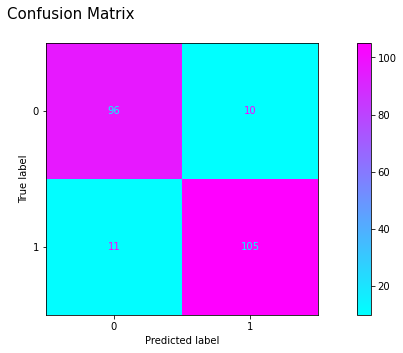

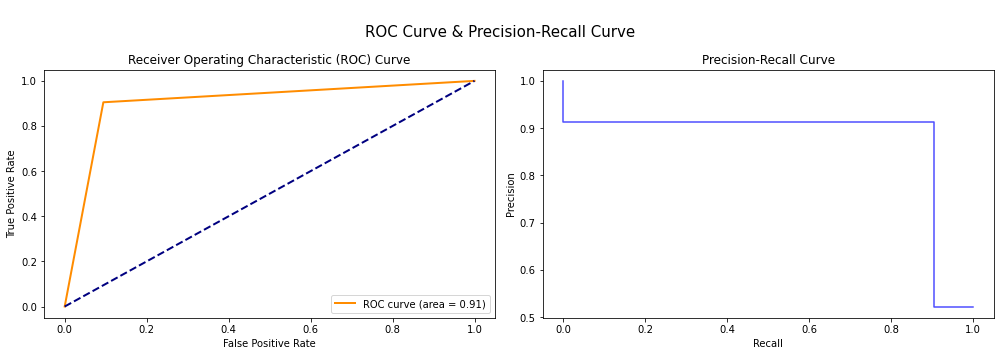

In [50]:
print("--------------- DT BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
decision_tree_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = decision_tree_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, decision_tree_model, Xtrain_bfs, ytrain)

model_results['Decision Tree BFS'] = results

### Hyperparameter Tuning

--------------- DT BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'cramping', 'back_pain', 'painful_bowel_movements', 'menstrual_clots', 'infertility', 'painful_cramps_during_period', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'stomach_cramping', 'migraines', 'extreme_or_severe_pain', 'leg_pain', 'irritable_bowel_syndrome_(ibs)', 'bleeding', 'ovarian_cysts', 'ibs-like_symptoms', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'cysts_(unspecified)', 'malaise_or_sickness', 'fever', 'bloating', 'abdominal_cramps_during_intercourse', 'insomnia_or_sleeplessness', 'acne_or_pimples']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 144 candidates, totalling 720 fits
{'criterion': 'entropy'

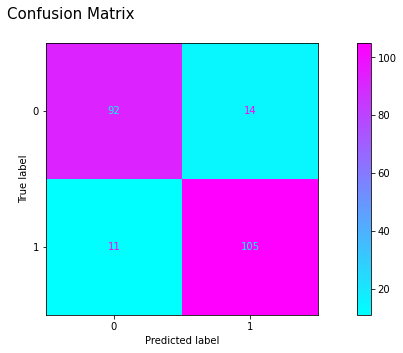

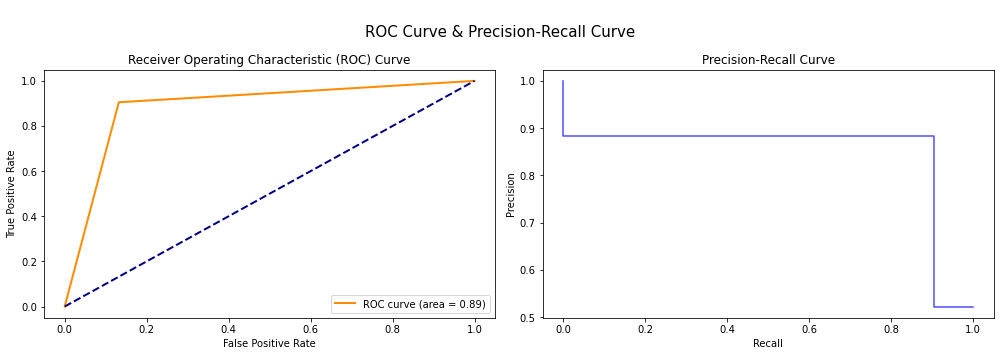

In [51]:
print("--------------- DT BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(decision_tree_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
decision_tree_model = DecisionTreeClassifier()

gsDT = GridSearchCV(decision_tree_model, dt_params, cv=5, n_jobs=-1, verbose=1)
gsDT.fit(Xtrain_bfs, ytrain)

print(gsDT.best_params_)
print(gsDT.best_score_)

print("--------------- Model Training ---------------")
gs_decision_tree_model = gsDT.best_estimator_

# Train the model
gs_decision_tree_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_decision_tree_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_decision_tree_model, Xtrain_bfs, ytrain)

model_results['Decision Tree BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- DT PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

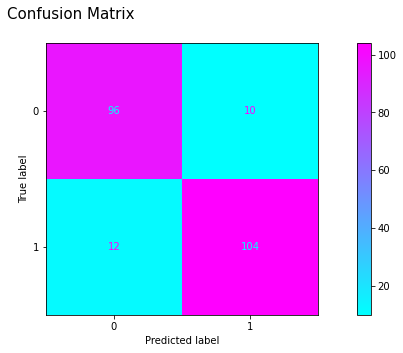

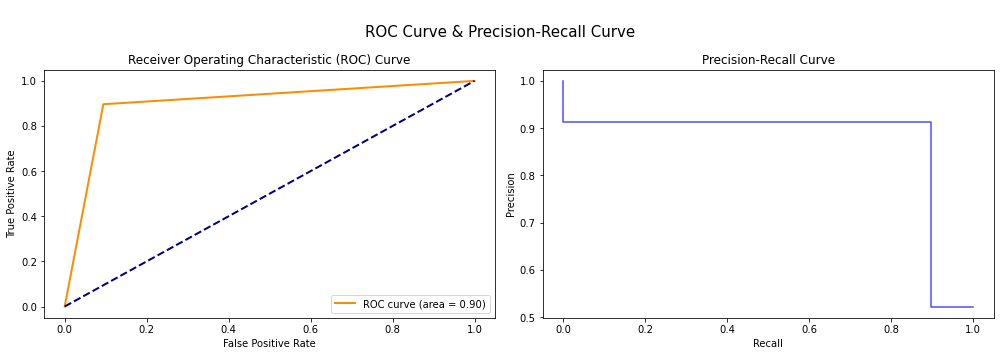

In [52]:
print("--------------- DT PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_dt_model = DecisionTreeClassifier()

# Train the model
pca_dt_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_dt_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_dt_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA(58)'] = results

### Hyperparameter Tuning

--------------- DT PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dysp

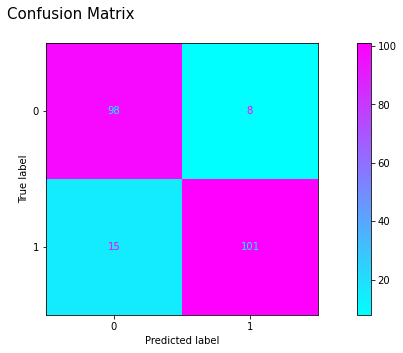

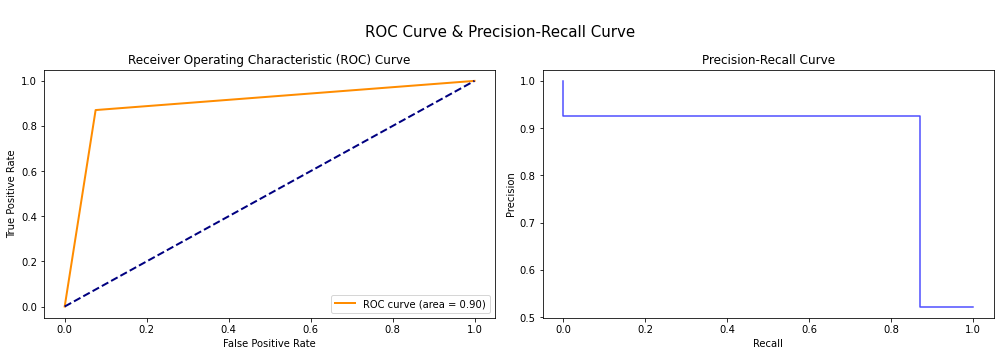

In [53]:
print("--------------- DT PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
decision_tree_model = DecisionTreeClassifier()

gsDT = GridSearchCV(decision_tree_model, dt_params, cv=5, n_jobs=-1, verbose=1)
gsDT.fit(Xtrain_pca, ytrain)

print(gsDT.best_params_)
print(gsDT.best_score_)

print("--------------- Model Training ---------------")
gs_decision_tree_model = gsDT.best_estimator_

# Train the model
gs_decision_tree_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_decision_tree_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_decision_tree_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA(58) Hyp'] = results

#### Version 2 

--------------- DT PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'infertility']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimples

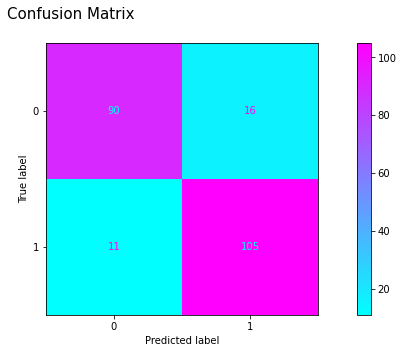

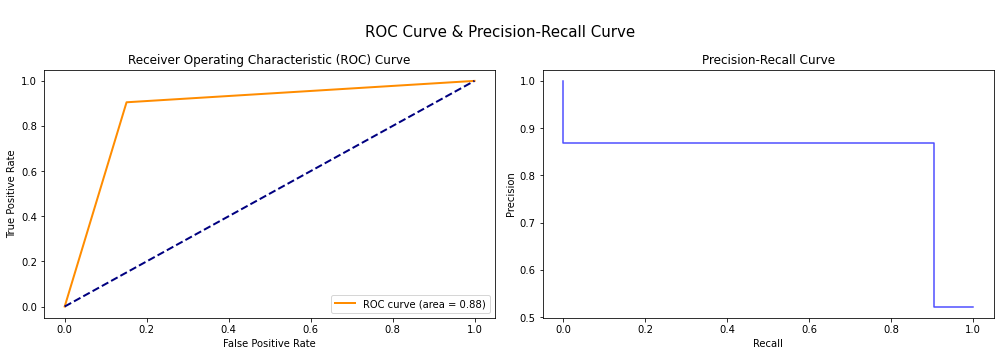

In [54]:
print("--------------- DT PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_dt_model = DecisionTreeClassifier()

# Train the model
pca_dt_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_dt_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_dt_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA (29)'] = results

###  Hyperparameter Tuning

--------------- DT PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dysp

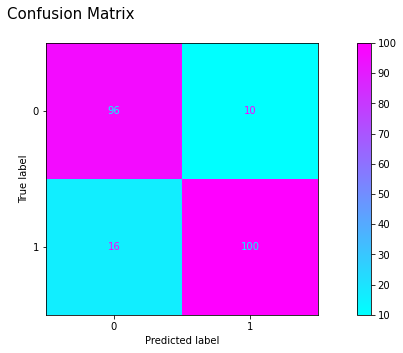

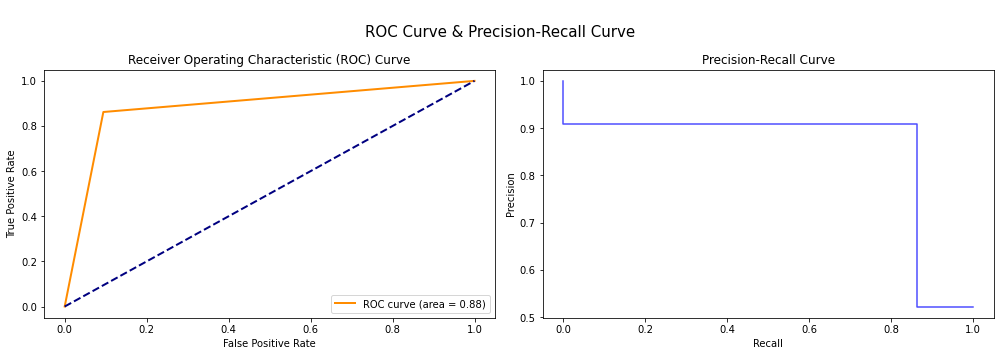

In [55]:
print("--------------- DT PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
decision_tree_model = DecisionTreeClassifier()

gsDT = GridSearchCV(decision_tree_model, dt_params, cv=5, n_jobs=-1, verbose=1)
gsDT.fit(Xtrain_pca, ytrain)

print(gsDT.best_params_)
print(gsDT.best_score_)

print("--------------- Model Training ---------------")
gs_decision_tree_model = gsDT.best_estimator_

# Train the model
gs_decision_tree_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_decision_tree_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_decision_tree_model, Xtrain_pca, ytrain)

model_results['Decision Tree PCA(29) Hyp'] = results

## Support Vector Machine (SVM)
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.905
Precision: 0.886
Recall: 0.94
F1 Score: 0.912
ROC AUC: 0.904
Standard Deviaiton (Accuracy): 0.0195

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.93      0.87      0.90       106
1 - Positive       0.89      0.94      0.91       116

    accuracy                           0.91       222
   macro avg       0.91      0.90      0.90       222
weighted avg       0.91      0.91      0.91       222


--------------- Visual Evaluation ---------------


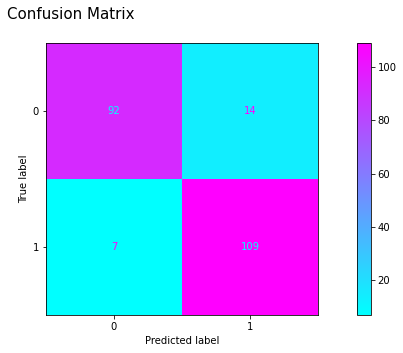

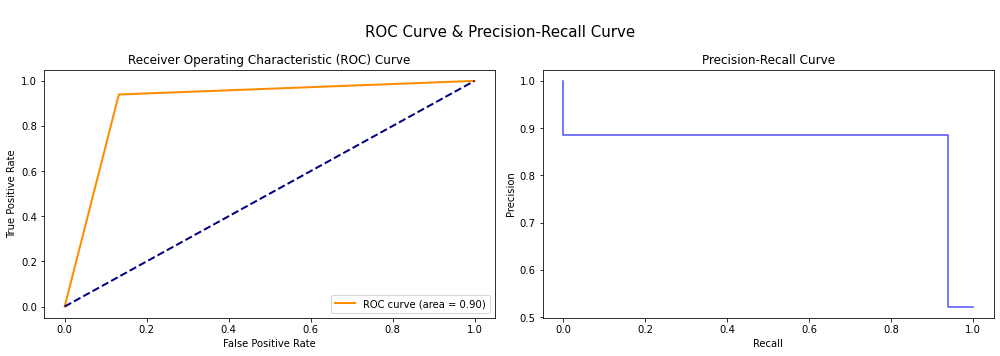

In [56]:
svm_model = svm.SVC(kernel='linear')

svm_model.fit(Xtrain, ytrain)
ypred = svm_model.predict(Xtest)

results = evaluate(ytest, ypred, svm_model, Xtrain, ytrain)

model_results['SVM'] = results

In [57]:
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

### Hyperparameter Tuning

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.93071314650262

--------------- Evaluation ---------------
Accuracy: 0.95
Precision: 0.957
Recall: 0.948
F1 Score: 0.952
ROC AUC: 0.951
Standard Deviaiton (Accuracy): 0.0267

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.94      0.95      0.95       106
1 - Positive       0.96      0.95      0.95       116

    accuracy                           0.95       222
   macro avg       0.95      0.95      0.95       222
weighted avg       0.95      0.95      0.95       222


--------------- Visual Evaluation ---------------


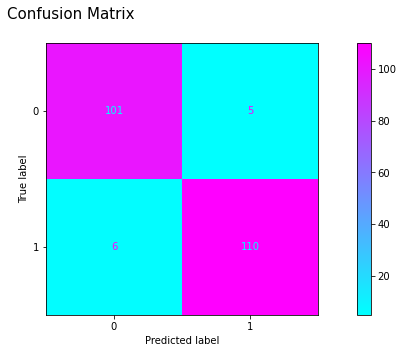

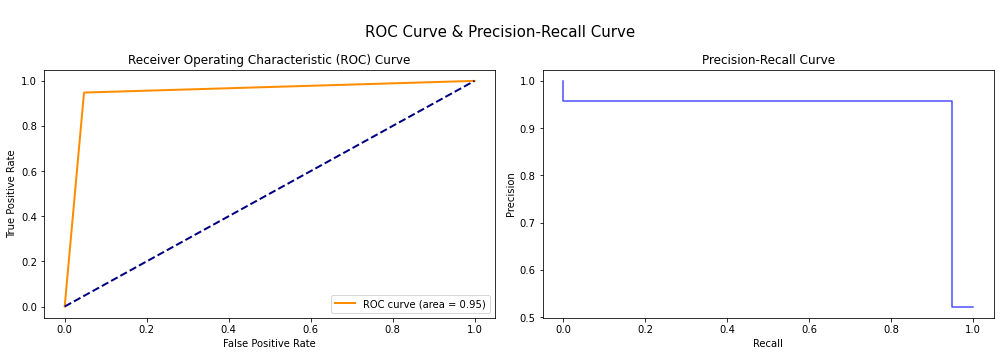

In [58]:
#base model (using the default)
svm_model = svm.SVC(kernel='linear')

gsSVM = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
gsSVM.fit(Xtrain, ytrain)

print(gsSVM.best_params_)
print(gsSVM.best_score_)

gs_svm_model = gsSVM.best_estimator_

gs_svm_model.fit(Xtrain, ytrain)
ypred = gs_svm_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_svm_model, Xtrain, ytrain)

model_results['SVM Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- SVM FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'extreme_or_severe_pain', 'irritable_bowel_syndrome_(ibs)', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'painful_urination', 'constant_bleeding', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'bowel_pain', 'malaise_or_sickness', 'fever', 'decreased_energy_or_exhaustion', 'acne_or_pimples']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.923
Precision: 0.896
Recall: 0.

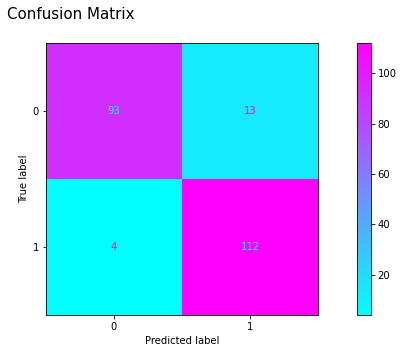

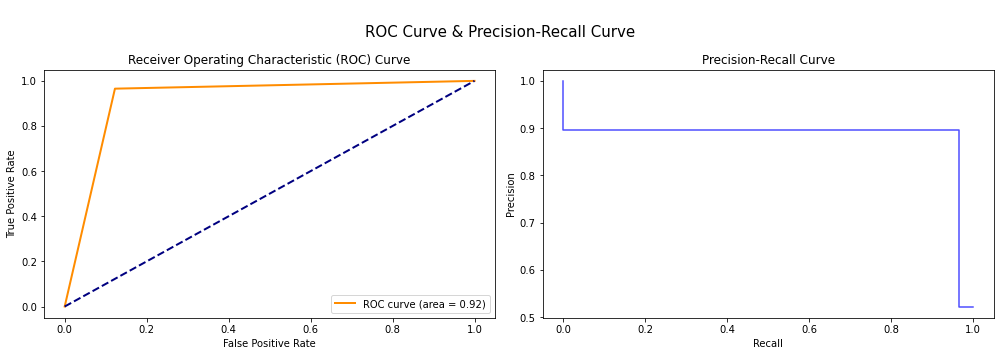

In [59]:
print("--------------- SVM FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
svm_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = svm_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, svm_model, Xtrain_ffs, ytrain)

model_results['SVM FFS'] = results

### Hyperparameter Tuning 

--------------- SVM FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'long_menstruation', 'constipation_or_chronic_constipation', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'migraines', 'extreme_or_severe_pain', 'irritable_bowel_syndrome_(ibs)', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'painful_urination', 'constant_bleeding', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'bowel_pain', 'malaise_or_sickness', 'fever', 'decreased_energy_or_exhaustion', 'acne_or_pimples']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
{'C': 1, 'degr

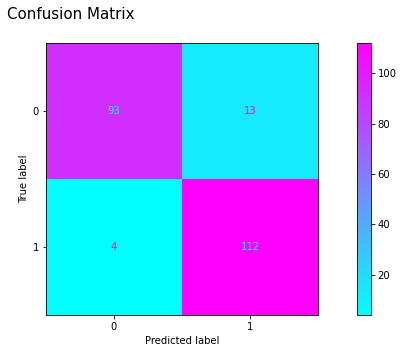

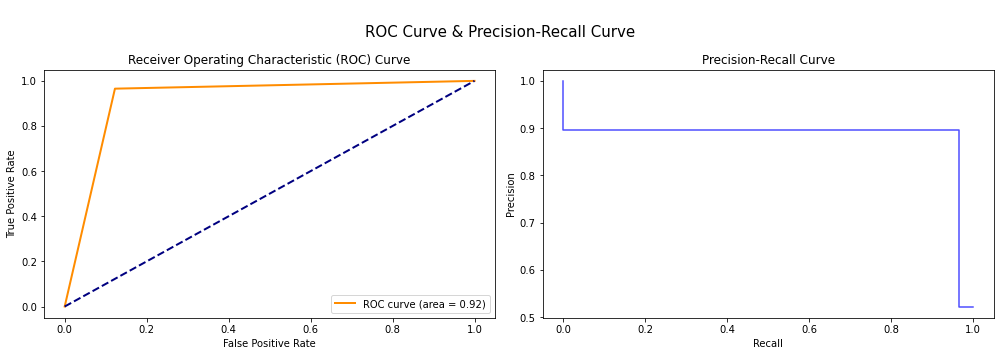

In [60]:
print("--------------- SVM FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
svm_model = svm.SVC(kernel='linear')

gsSVM = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
gsSVM.fit(Xtrain_ffs, ytrain)

print(gsSVM.best_params_)
print(gsSVM.best_score_)

print("--------------- Model Training ---------------")
gs_svm_model = gsSVM.best_estimator_

# Train the model
gs_svm_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_svm_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_svm_model, Xtrain_ffs, ytrain)

model_results['SVM FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- SVM BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 

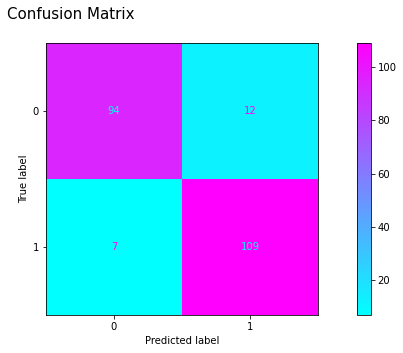

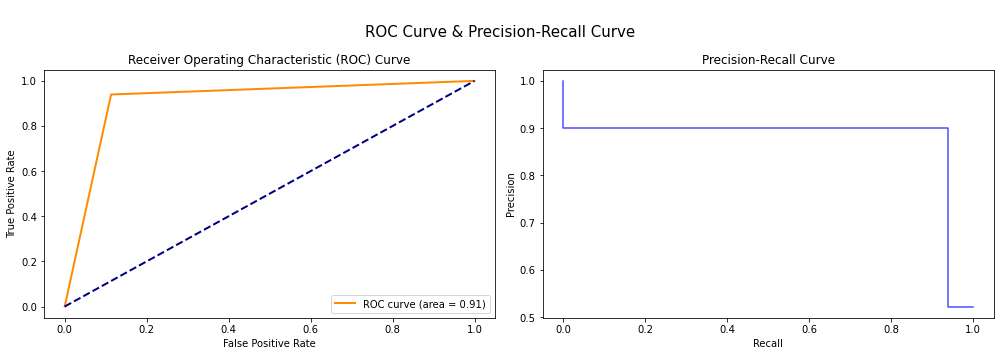

In [61]:
print("--------------- SVM BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
svm_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = svm_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, svm_model, Xtrain_bfs, ytrain)

model_results['SVM BFS'] = results

### Hyperparameter Tuning 

--------------- SVM BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'abdominal_pain_or_pressure', 'painful_bowel_movements', 'infertility', 'long_menstruation', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'digestive_or_gi_problems', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 300 candidates, t

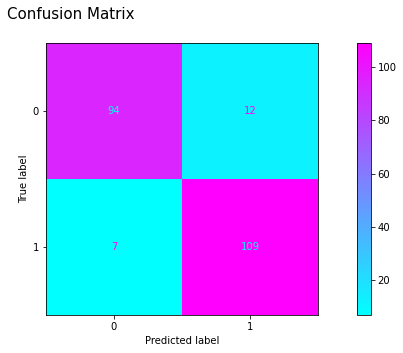

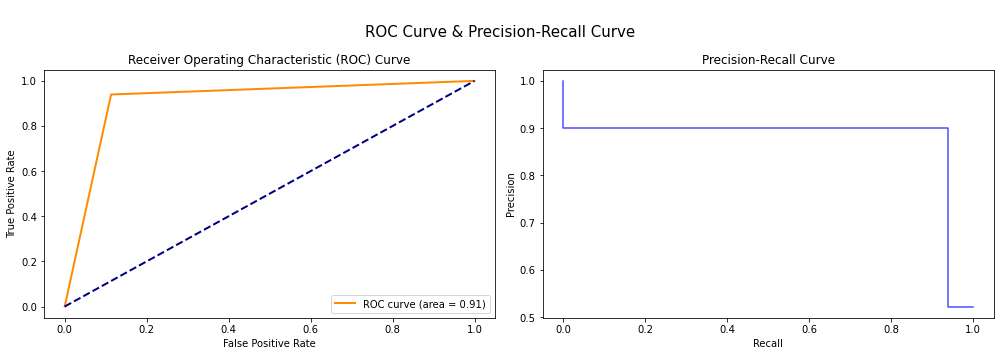

In [62]:
print("--------------- SVM BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(svm_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
svm_model = svm.SVC(kernel='linear')

gsSVM = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
gsSVM.fit(Xtrain_bfs, ytrain)

print(gsSVM.best_params_)
print(gsSVM.best_score_)

print("--------------- Model Training ---------------")
gs_svm_model = gsSVM.best_estimator_

# Train the model
gs_svm_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_svm_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_svm_model, Xtrain_bfs, ytrain)

model_results['SVM BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- SVM PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_p

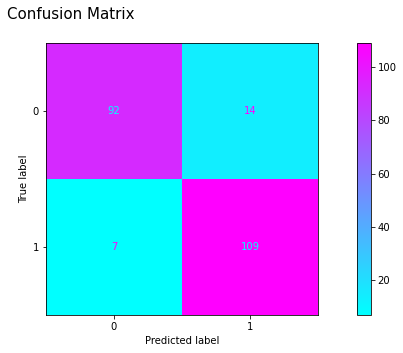

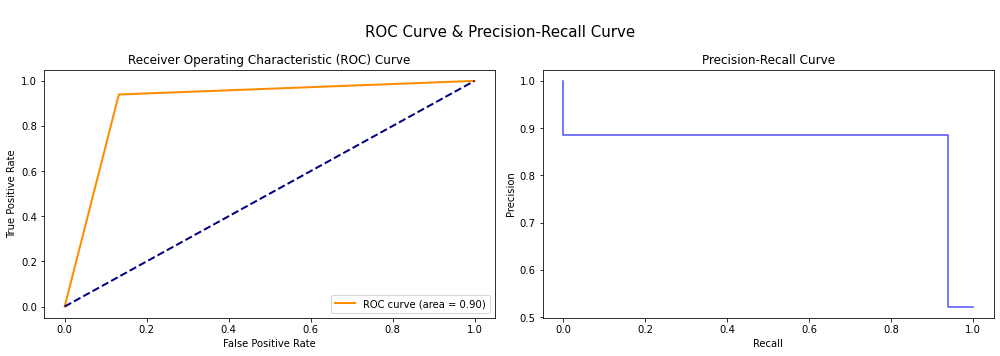

In [63]:
print("--------------- SVM PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_svm_model = svm.SVC(kernel='linear')

# Train the model
pca_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA(58)'] = results

### Hyperparameter Tuning 

--------------- SVM PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dys

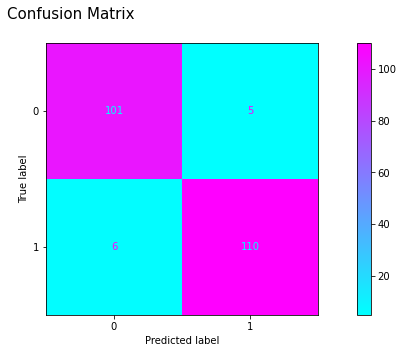

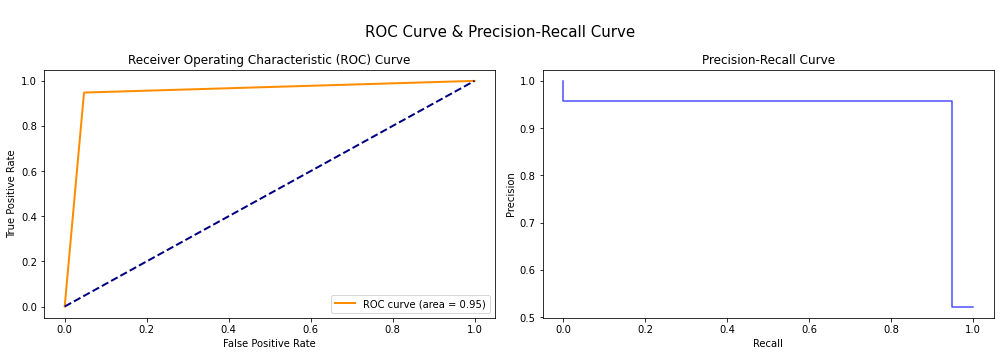

In [64]:
print("--------------- SVM PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
svm_model = svm.SVC(kernel='linear')

gsSVM = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
gsSVM.fit(Xtrain_pca, ytrain)

print(gsSVM.best_params_)
print(gsSVM.best_score_)

print("--------------- Model Training ---------------")
gs_svm_model = gsSVM.best_estimator_

# Train the model
gs_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA(58) Hyp'] = results

#### Version 2

--------------- SVM PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'infertility', 'headaches']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pimple

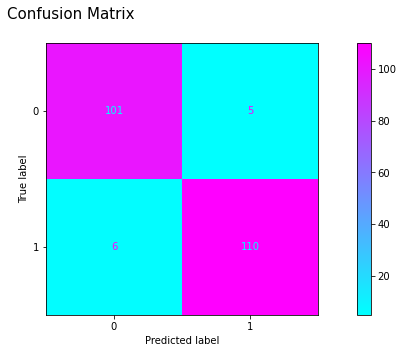

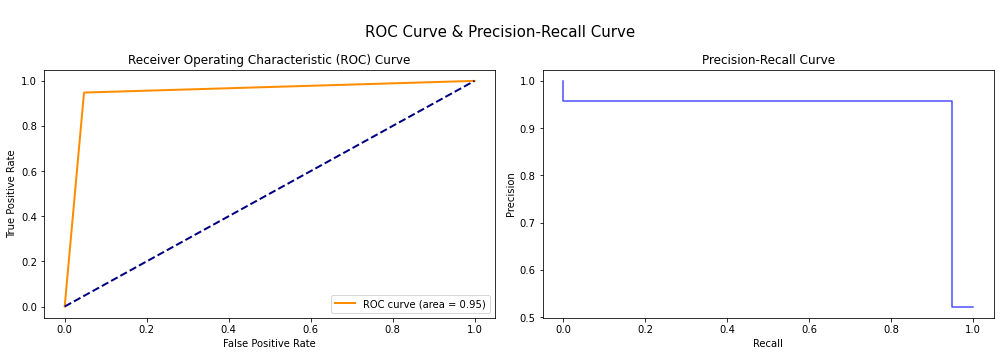

In [65]:
print("--------------- SVM PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_svm_model = svm.SVC(kernel='linear')

# Train the model
pca_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA (29)'] = results

### Hyperparameter Tuning 

--------------- SVM PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dys

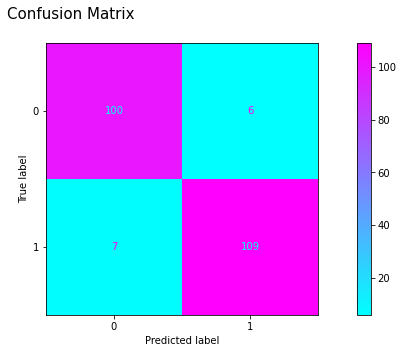

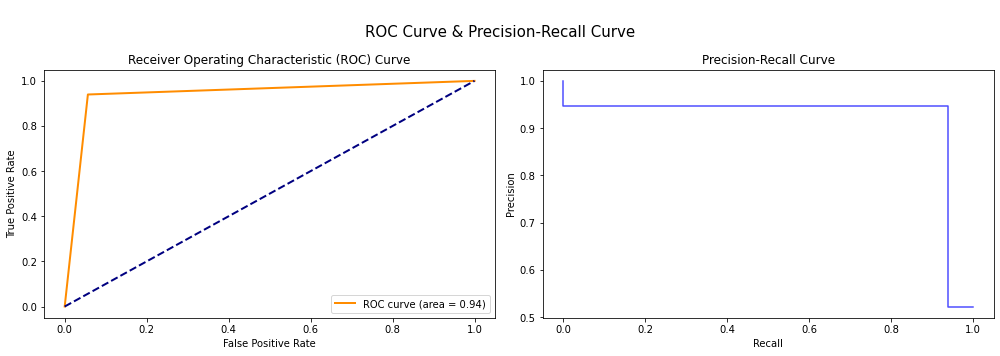

In [66]:
print("--------------- SVM PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
svm_model = svm.SVC(kernel='linear')

gsSVM = GridSearchCV(svm_model, svm_params, cv=5, n_jobs=-1, verbose=1)
gsSVM.fit(Xtrain_pca, ytrain)

print(gsSVM.best_params_)
print(gsSVM.best_score_)

print("--------------- Model Training ---------------")
gs_svm_model = gsSVM.best_estimator_

# Train the model
gs_svm_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_svm_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_svm_model, Xtrain_pca, ytrain)

model_results['SVM PCA(29) Hyp'] = results

## Adaboost
### Base Model


--------------- Evaluation ---------------
Accuracy: 0.932
Precision: 0.917
Recall: 0.957
F1 Score: 0.937
ROC AUC: 0.931
Standard Deviaiton (Accuracy): 0.0101

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.95      0.91      0.93       106
1 - Positive       0.92      0.96      0.94       116

    accuracy                           0.93       222
   macro avg       0.93      0.93      0.93       222
weighted avg       0.93      0.93      0.93       222


--------------- Visual Evaluation ---------------


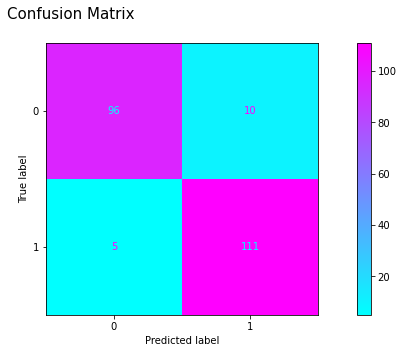

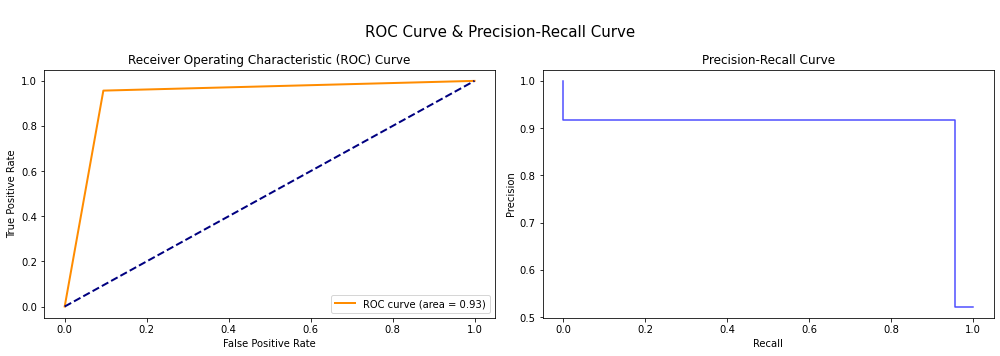

In [67]:
adaboost_model = AdaBoostClassifier()

adaboost_model.fit(Xtrain, ytrain)
ypred = adaboost_model.predict(Xtest)

results = evaluate(ytest, ypred, adaboost_model, Xtrain, ytrain)

model_results['AdaBoost'] = results

In [68]:
adaboost_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

### Hyperparameter Tuning 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 100}
0.9171793119161539

--------------- Evaluation ---------------
Accuracy: 0.941
Precision: 0.933
Recall: 0.957
F1 Score: 0.945
ROC AUC: 0.941
Standard Deviaiton (Accuracy): 0.0134

Classification Report: 
              precision    recall  f1-score   support

0 - Negative       0.95      0.92      0.94       106
1 - Positive       0.93      0.96      0.94       116

    accuracy                           0.94       222
   macro avg       0.94      0.94      0.94       222
weighted avg       0.94      0.94      0.94       222


--------------- Visual Evaluation ---------------


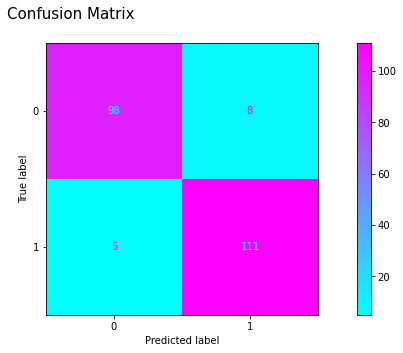

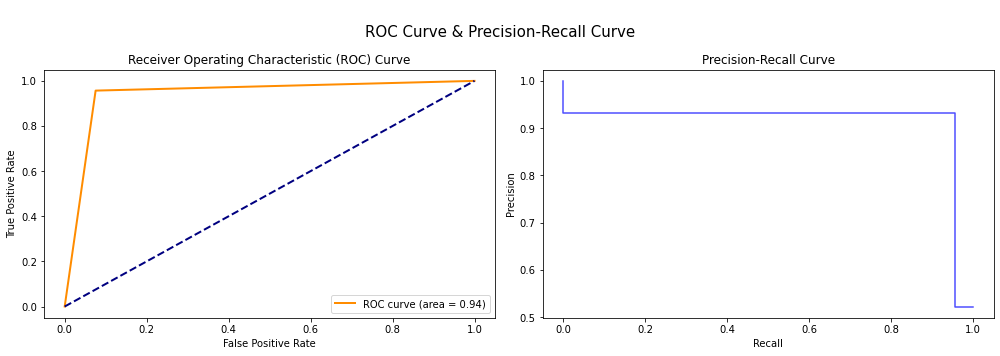

In [69]:
#base model (using the default)
adaboost_model = AdaBoostClassifier()

gsAda = GridSearchCV(adaboost_model, ada_params, cv=5, n_jobs=-1, verbose=1)
gsAda.fit(Xtrain, ytrain)

print(gsAda.best_params_)
print(gsAda.best_score_)

gs_adaboost_model = gsAda.best_estimator_

gs_adaboost_model.fit(Xtrain, ytrain)
ypred = gs_adaboost_model.predict(Xtest)

results = evaluate(ytest, ypred, gs_adaboost_model, Xtrain, ytrain)

model_results['AdaBoost Hyp'] = results
#model_results

### Wrapper Method: Forward Feature Selection

--------------- Adaboost FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_bowel_movements', 'nausea', 'menstrual_clots', 'painful_cramps_during_period', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'stomach_cramping', 'extreme_or_severe_pain', 'leg_pain', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'pain_after_intercourse', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.946
Precision: 0.94

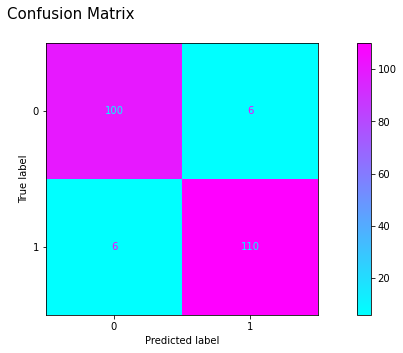

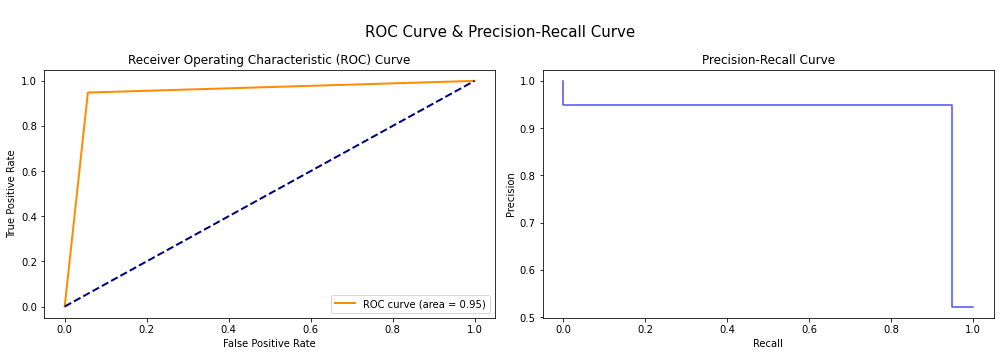

In [70]:
print("--------------- Adaboost FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
adaboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = adaboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, adaboost_model, Xtrain_ffs, ytrain)

model_results['Adaboost FFS'] = results

### Hyperparameter Tuning 

--------------- Adaboost FFS MODEL ---------------

--------------- Applying FFS ---------------

Features selected by Forward Feature Selection: 29

Features selected by Forward Feature Selection: ['heavy_or_extreme_menstrual_bleeding', 'menstrual_pain_(dysmenorrhea)', 'painful_bowel_movements', 'nausea', 'menstrual_clots', 'painful_cramps_during_period', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'stomach_cramping', 'extreme_or_severe_pain', 'leg_pain', 'depression', 'bleeding', 'lower_back_pain', 'fertility_issues', 'ovarian_cysts', 'constant_bleeding', 'pain_after_intercourse', 'digestive_or_gi_problems', 'excessive_bleeding', 'anaemia_or_iron_deficiency', 'vaginal_painorpressure', 'sharp_or_stabbing_pain', 'anxiety', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'decreased_energy_or_exhaustion', 'abdominal_cramps_during_intercourse']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'al

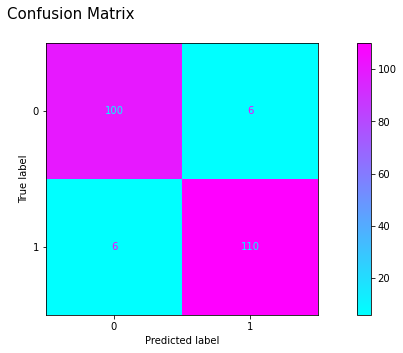

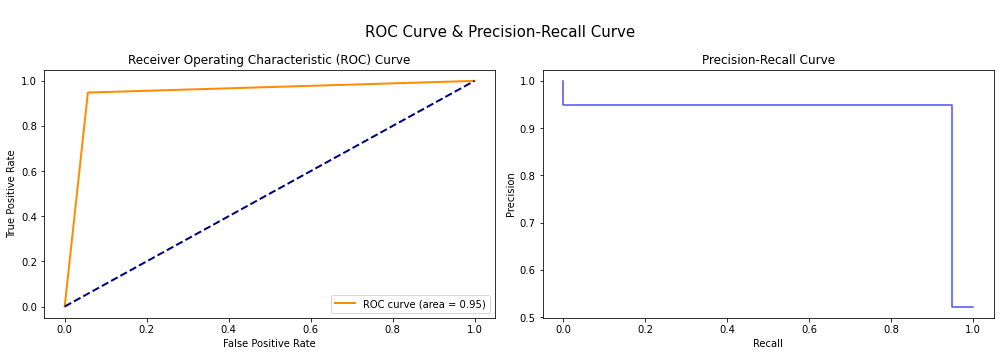

In [71]:
print("--------------- Adaboost FFS MODEL ---------------\n")

Xtrain_ffs, Xtest_ffs = apply_ffs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
adaboost_model = AdaBoostClassifier()

gsAda = GridSearchCV(adaboost_model, ada_params, cv=5, n_jobs=-1, verbose=1)
gsAda.fit(Xtrain_ffs, ytrain)

print(gsAda.best_params_)
print(gsAda.best_score_)

print("--------------- Model Training ---------------")
gs_adaboost_model = gsAda.best_estimator_

# Train the model
gs_adaboost_model.fit(Xtrain_ffs, ytrain)

# Predict on the test data
ypred = gs_adaboost_model.predict(Xtest_ffs)

results = evaluate(ytest, ypred, gs_adaboost_model, Xtrain_ffs, ytrain)

model_results['Adaboost FFS Hyp'] = results

### Wrapper Method: Backward Feature Selection

--------------- Adaboost BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- Model Training ---------------

--------------- Evaluation ---------------
Accuracy: 0.923
Precision: 0.909
Re

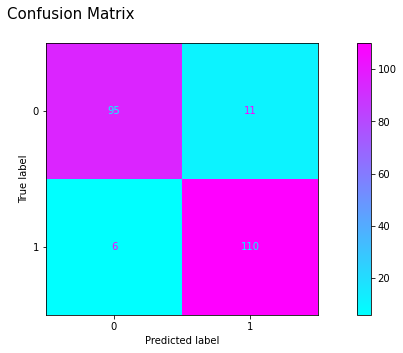

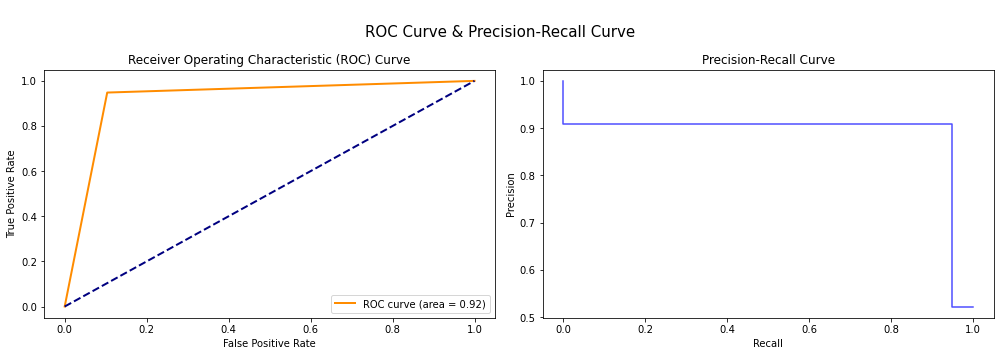

In [72]:
print("--------------- Adaboost BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- Model Training ---------------")
# Train the model
adaboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = adaboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, adaboost_model, Xtrain_bfs, ytrain)

model_results['Adaboost BFS'] = results

###  Hyperparameter Tuning

--------------- Adaboost BFS MODEL ---------------

--------------- Applying BFS ---------------

Features selected by Backward Feature Selection: 29

Features selected by Backward Feature Selection: ['menstrual_pain_(dysmenorrhea)', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'pelvic_pain', 'irregular_or_missed_periods', 'cramping', 'back_pain', 'painful_bowel_movements', 'painful_cramps_during_period', 'pain_or_chronic_pain', 'constipation_or_chronic_constipation', 'vomiting_or_constant_vomiting', 'fatigue_or_chronic_fatigue', 'painful_ovulation', 'mood_swings', 'bleeding', 'fertility_issues', 'ovarian_cysts', 'headaches', 'constant_bleeding', 'ibs-like_symptoms', 'bowel_pain', 'cysts_(unspecified)', 'dizziness', 'malaise_or_sickness', 'abnormal_uterine_bleeding', 'fever', 'hormonal_problems', 'abdominal_cramps_during_intercourse', 'loss_of_appetite']
--------------- HyperParameter Tuning  ---------------

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'algori

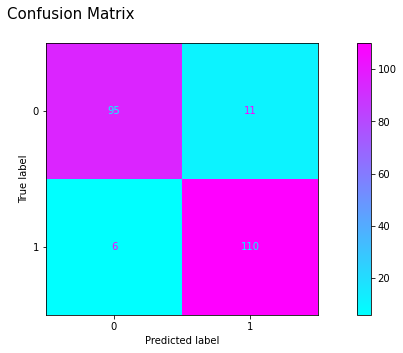

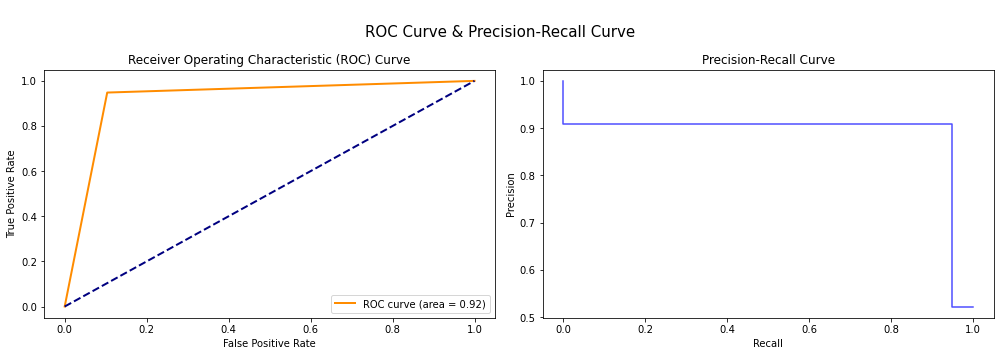

In [73]:
print("--------------- Adaboost BFS MODEL ---------------\n")

Xtrain_bfs, Xtest_bfs = apply_bfs(adaboost_model, Xtrain, Xtest, ytrain, X.columns)

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
adaboost_model = AdaBoostClassifier()

gsAda = GridSearchCV(adaboost_model, ada_params, cv=5, n_jobs=-1, verbose=1)
gsAda.fit(Xtrain_bfs, ytrain)

print(gsAda.best_params_)
print(gsAda.best_score_)

print("--------------- Model Training ---------------")
gs_adaboost_model = gsAda.best_estimator_

# Train the model
gs_adaboost_model.fit(Xtrain_bfs, ytrain)

# Predict on the test data
ypred = gs_adaboost_model.predict(Xtest_bfs)

results = evaluate(ytest, ypred, gs_adaboost_model, Xtrain_bfs, ytrain)

model_results['Adaboost BFS Hyp'] = results

### Linear Dimentionality Reduction Method: Principal Component Analysis (PCA)

--------------- LR PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne_or_pi

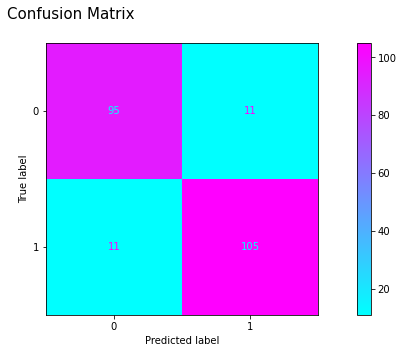

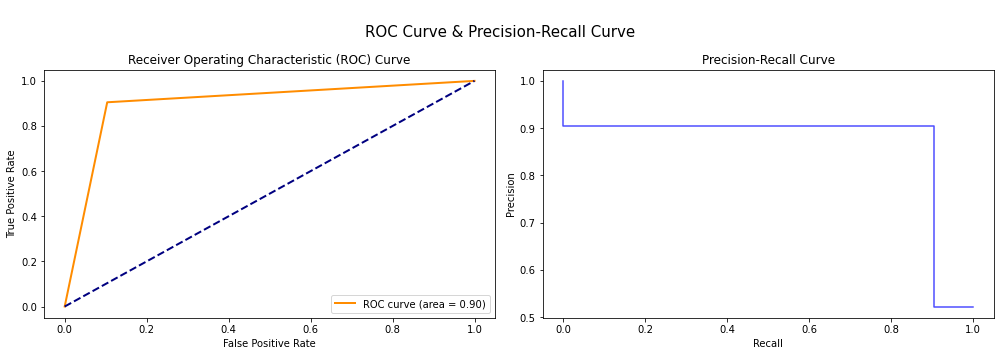

In [74]:
print("--------------- LR PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_adaboost_model = AdaBoostClassifier()

# Train the model
pca_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA(58)'] = results

### Hyperparameter Tuning 

--------------- Adaboost PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 58
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex

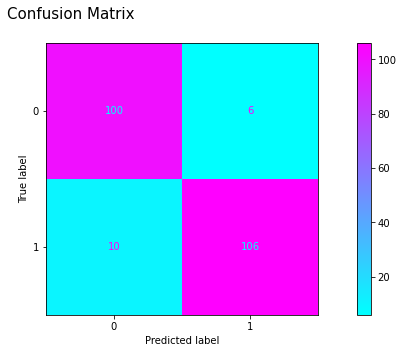

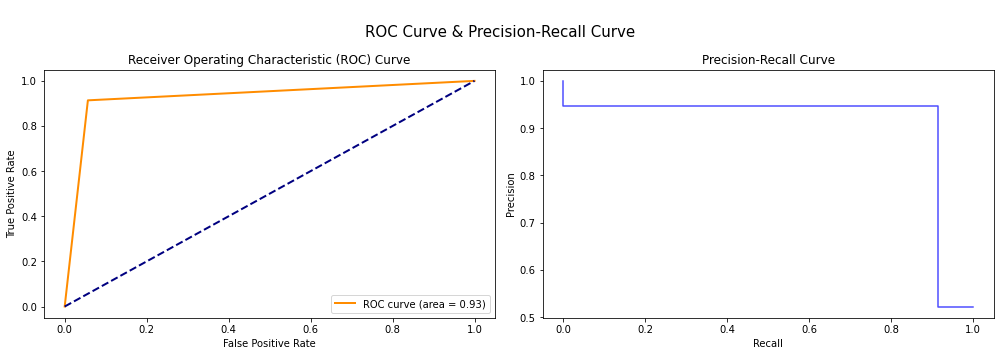

In [75]:
print("--------------- Adaboost PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 58) # n components = 58

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
adaboost_model = AdaBoostClassifier()

gsAda = GridSearchCV(adaboost_model, ada_params, cv=5, n_jobs=-1, verbose=1)
gsAda.fit(Xtrain_pca, ytrain)

print(gsAda.best_params_)
print(gsAda.best_score_)

print("--------------- Model Training ---------------")
gs_adaboost_model = gsAda.best_estimator_

# Train the model
gs_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA(58) Hyp'] = results

#### Version 2 

--------------- Adaboost PCA MODEL ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'headaches', 'loss_of_appetite']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'cysts_(unspecified)', 'back_pain']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex_(dyspareunia)', 'acne

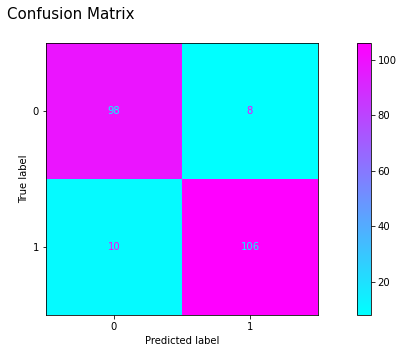

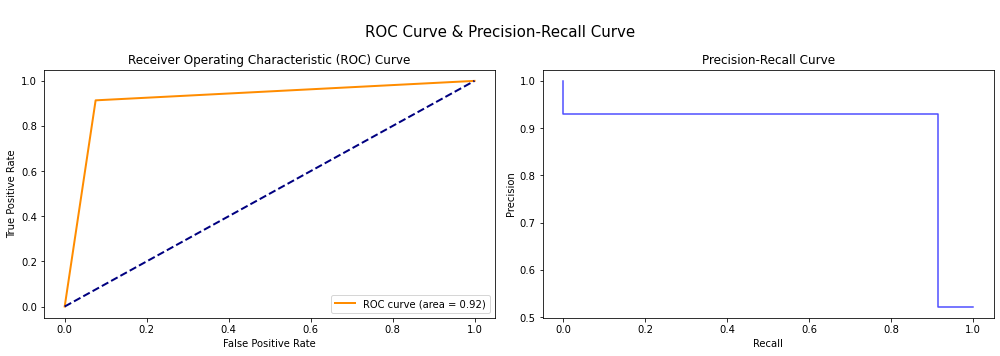

In [76]:
print("--------------- Adaboost PCA MODEL ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- Model Training ---------------")

# Initialize the Logistic Regression model
pca_adaboost_model = AdaBoostClassifier()

# Train the model
pca_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = pca_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, pca_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA (29)'] = results

### Hyperparameter Tuning 

--------------- Adaboost PCA MODEL HYPERPARAMETER TUNING ---------------

--------------- Applying PCA ---------------
Number of Principal Components: 29
Component 0: ['abdominal_pain_or_pressure', 'menstrual_pain_(dysmenorrhea)', 'painful_cramps_during_period']
Component 1: ['heavy_or_extreme_menstrual_bleeding', 'bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 2: ['back_pain', 'lower_back_pain', 'loss_of_appetite']
Component 3: ['migraines', 'bleeding', 'headaches']
Component 4: ['depression', 'leg_pain', 'anxiety']
Component 5: ['bleeding', 'heavy_or_extreme_menstrual_bleeding', 'painful_or_burning_pain_during_sex_(dyspareunia)']
Component 6: ['nausea', 'loss_of_appetite', 'headaches']
Component 7: ['irritable_bowel_syndrome_(ibs)', 'loss_of_appetite', 'diarrhea']
Component 8: ['infertility', 'back_pain', 'cysts_(unspecified)']
Component 9: ['stomach_cramping', 'cramping', 'pain_or_chronic_pain']
Component 10: ['diarrhea', 'painful_or_burning_pain_during_sex

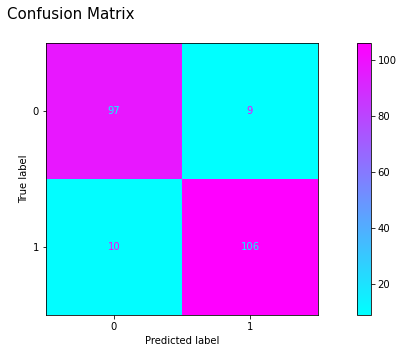

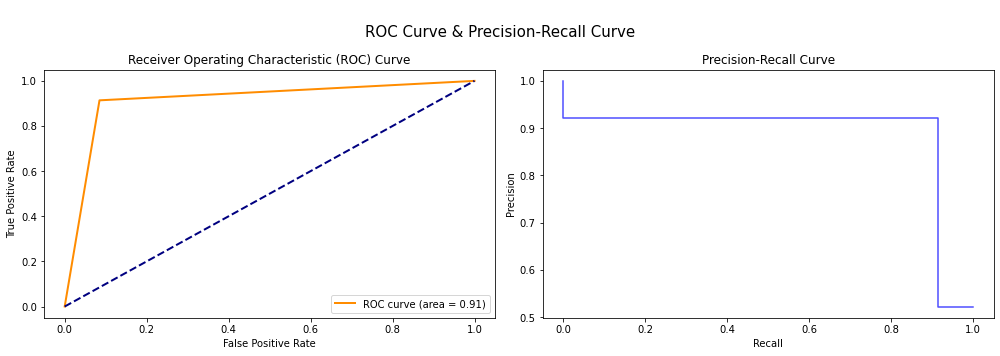

In [77]:
print("--------------- Adaboost PCA MODEL HYPERPARAMETER TUNING ---------------\n")

Xtrain_pca, Xtest_pca = apply_pca(Xtrain, Xtest, X.columns, 29) # n components = 29

print("--------------- HyperParameter Tuning  ---------------\n")
#base model (using the default)
adaboost_model = AdaBoostClassifier()

gsAda = GridSearchCV(adaboost_model, ada_params, cv=5, n_jobs=-1, verbose=1)
gsAda.fit(Xtrain_pca, ytrain)

print(gsAda.best_params_)
print(gsAda.best_score_)

print("--------------- Model Training ---------------")
gs_adaboost_model = gsAda.best_estimator_

# Train the model
gs_adaboost_model.fit(Xtrain_pca, ytrain)

# Predict on the test data
ypred = gs_adaboost_model.predict(Xtest_pca)

results = evaluate(ytest, ypred, gs_adaboost_model, Xtrain_pca, ytrain)

model_results['Adaboost PCA(29) Hyp'] = results

## Model Results

In [78]:
model_results.head(6) #should be 61 cols for hyperparameters

,Metrics,Logistic Regression,Logistic Regression Hyp,Logistic Regression FFS,Logistic Regression FFS Hyp,Logistic Regression BFS,Logistic Regression BFS Hyp,Logistic Regression PCA(58),Logistic Regression PCA(58) Hyp,Logistic Regression PCA (29),...,AdaBoost,AdaBoost Hyp,Adaboost FFS,Adaboost FFS Hyp,Adaboost BFS,Adaboost BFS Hyp,Adaboost PCA(58),Adaboost PCA(58) Hyp,Adaboost PCA (29),Adaboost PCA(29) Hyp
0,Accuracy,0.945946,0.945946,0.950450,0.941441,0.941441,0.936937,0.945946,0.905405,0.941441,...,0.932432,0.941441,0.945946,0.945946,0.923423,0.923423,0.900901,0.927928,0.918919,0.914414
1,Precision,0.956140,0.956140,0.956522,0.940171,0.947826,0.939655,0.956140,0.886179,0.955752,...,0.917355,0.932773,0.948276,0.948276,0.909091,0.909091,0.905172,0.946429,0.929825,0.921739
2,Recall,0.939655,0.939655,0.948276,0.948276,0.939655,0.939655,0.939655,0.939655,0.931034,...,0.956897,0.956897,0.948276,0.948276,0.948276,0.948276,0.905172,0.913793,0.913793,0.913793
3,F1Score,0.947826,0.947826,0.952381,0.944206,0.943723,0.939655,0.947826,0.912134,0.943231,...,0.936709,0.944681,0.948276,0.948276,0.928270,0.928270,0.905172,0.929825,0.921739,0.917749
4,ROC AUC,0.946243,0.946243,0.950553,0.941119,0.941526,0.936809,0.946243,0.903790,0.941932,...,0.931278,0.940712,0.945836,0.945836,0.922251,0.922251,0.900699,0.928595,0.919161,0.914444
5,Standard Dev,0.008241,0.019608,0.023512,0.023712,0.023946,0.024511,0.008241,0.011293,0.021142,...,0.010142,0.013388,0.014171,0.014171,0.023120,0.023120,0.018461,0.014708,0.021290,0.012184


In [79]:
model_results.to_csv('../results/hyperparameter_clinical_model_results.csv', index=True)  